### Initial Setup and Imports
- Purpose: This cell is the foundation of the notebook, where essential libraries are imported for data analysis and manipulation.
- Libraries:
1. **numpy** and **pandas**: Widely used for numerical and data manipulation tasks. numpy offers support for arrays and matrices, while pandas provides more sophisticated data structures and operations for manipulating tables.
1. **mne**: A library specifically designed for analyzing neurophysiological data, including EEG, MEG, and fNIRS data. It's a powerful tool for preprocessing, visualizing, decoding, and statistical analysis.
1. **os** and **glob**: These libraries are used for operating system and file path operations, allowing the script to interact with the system to read files and navigate directories.
1. **compress** from **itertools**: Useful for filtering data, potentially to select specific subsets of data based on some criteria.
1. **tqdm**: A library that provides a progress meter, very useful for long-running operations to give feedback on the progress of the operation.
1. **matplotlib**: a comprehensive library for creating static, animated, and interactive visualizations in Python.
1. **Axes3D** from **mpl_toolkits.mplot3d** is specifically for 3D plotting
1. **io**:  Used for handling various input/output operations, such as reading from or writing to files.
1. **copy**: Provides the ability to make deep copies of data structures, ensuring that modifications do not affect the original data.
1. **OrderedDict** from **collections**: Useful for maintaining the order of elements in a dictionary, which can be important for data processing where the sequence matters.
1. **requests**: This library is used for making HTTP requests to external services, like for fetching data or interacting with APIs.


*About Wavelet Analysis: Wavelet analysis is a powerful tool for time-frequency analysis, particularly useful in analyzing neurophysiological signals where different frequency components may change over time.

In [11]:
#RUN THE NIRS Event Conversion SCRIPT WHEN NEW SUBJECTS HAVE BEEN ADDED
# general dependencies for Python and MNE (Python native fNIRS wavelet analysis)
import numpy as np
import pandas as pd
import mne
import os
from glob import glob
from itertools import compress
from tqdm import tqdm
import random

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import io
from copy import copy
from collections import OrderedDict
import requests

#dependencies for PyCWT, another wavelet analysis package
import pycwt as wavelet
from pycwt.helpers import find

# LCBD dependencies
# add relative path to the toolbox created by Dr. Susan Perlman's lab
import sys
sys.path.append('../../')
from LCBDtools.src import argParser
from LCBDtools.src import Plots

### Checking Python Version

- **Objective**: This block checks and displays the Python version used in the notebook. Ensuring compatibility of the libraries and syntax with the Python version.
- **Method**: Uses python_version from the platform library, which is a straightforward way to retrieve the Python interpreter's version.
- **Notes**: Make sure that your environment has python version 3.7.16 or 3.7.5

In [12]:
#Python version (make sure it is 3.7)
from platform import python_version
python_version()

'3.7.16'

### Setting Configuration Variables
- **Objective**: Defines important variables for managing the dataset and analysis parameters.
- **Configuration Details**:     
study_dir: Specifies the directory containing the cleaned NIRS data.    
participant_num_len: Sets a standard length for participant identifiers, this number is used when parsing file names or IDs. E.g. for pcat R56 = 4 but for R01 =5    
ex_subs: An empty list, intended to exclude specific subjects from the analysis by adding their IDs.     
durations: A dictionary mapping each "block" (or trial) to its duration, indicating structured experimental segments.    

In [13]:
# Important configuration variables
study_dir = "data/NIRS_data_clean"
participant_num_len = 4 # default length of participant numbers
ex_subs = [] # any subjects to not include in the dataset
debug = True

# set block durations (these are actually trial durations, an entire block was 4 trials, approx 480 seconds for each dyad)
durations = {
    'Block 1': 105, 
    'Block 2': 105, ## there was an issue with R56 stimuli that the video only lasted 105 instead of 120 as we intended
    'Block 3': 105} 

## I excluded the following participants from any part of this script:
# 1142 and 1249 had interrupted visits and possible admin errors
# 1191  for some reasons it halts the script from runnning when included.

### Defining Regions of Interest (ROIs)

- **Objective**: Identifies specific regions of the brain (ROIs) and associates them with data channels from the fNIRS device.

In [14]:
# set the channels for each ROI
ROIs = {
    'Left Frontal': ['S3_D2 hbo', 'S4_D2 hbo'],
    'Right Frontal': ['S5_D3 hbo', 'S6_D3 hbo'],
    'Left Temporal': ['S1_D1 hbo', 'S2_D1 hbo', 'S2_D2 hbo'],
    'Right Temporal': ['S7_D3 hbo', 'S7_D4 hbo', 'S8_D4 hbo']}

### Organizing Session Directories and Subjects

- **Objective**: Creates a list of session directories for each subject, followed by extracting and organizing subject identifiers.
- **Key Actions**:     
Uses globbing to find all directories matching a pattern within the study directory, focusing on those ending with "-C" or "-P" which -C = child and -P = parent.    
Extracts subject IDs from these directory names, ensuring uniqueness by converting the list to a set and then back to a list.     

In [15]:
# make a list of all matching session paths for each subject
#session_dirs = [d for d in glob(study_dir+"/*/*_fNIRS")]
session_dirs = [d for d in glob(study_dir + "/*/*") if d.endswith("-C") or d.endswith("-P")]


subjects = list(set([os.path.basename(d)[:participant_num_len] for d in session_dirs]))

### Displaying Session Directories

- **Objective**: Simply outputs the list of session directories to double check that our paths are correctly and we are refering to the right participants and files

In [16]:
session_dirs

['data/NIRS_data_clean/1264/1264-P',
 'data/NIRS_data_clean/1264/1264-C',
 'data/NIRS_data_clean/1263/1263-C',
 'data/NIRS_data_clean/1263/1263-P',
 'data/NIRS_data_clean/1255/1255-P',
 'data/NIRS_data_clean/1255/1255-C',
 'data/NIRS_data_clean/1252/1252-C',
 'data/NIRS_data_clean/1252/1252-P',
 'data/NIRS_data_clean/1239/1239-C',
 'data/NIRS_data_clean/1239/1239-P',
 'data/NIRS_data_clean/1237/1237-P',
 'data/NIRS_data_clean/1237/1237-C',
 'data/NIRS_data_clean/1253/1253-C',
 'data/NIRS_data_clean/1253/1253-P',
 'data/NIRS_data_clean/1254/1254-P',
 'data/NIRS_data_clean/1254/1254-C',
 'data/NIRS_data_clean/1265/1265-P',
 'data/NIRS_data_clean/1265/1265-C',
 'data/NIRS_data_clean/1231/1231-C',
 'data/NIRS_data_clean/1231/1231-P',
 'data/NIRS_data_clean/1236/1236-P',
 'data/NIRS_data_clean/1236/1236-C',
 'data/NIRS_data_clean/1209/1209-C',
 'data/NIRS_data_clean/1209/1209-P',
 'data/NIRS_data_clean/1200/1200-C',
 'data/NIRS_data_clean/1200/1200-P',
 'data/NIRS_data_clean/1207/1207-P',
 

### Counting Session Directories
- **Objective**: This line of code calculates the total number of session directories identified in the previous step. This is a proxy for how many participants we have in our files

In [17]:
len(session_dirs)

240

### Calculating the number of "pairs" 
- **Objective**: This line of code calculates the approximate number of dyads/pairs we have in our study by dividing the previous output by 2

In [18]:
len(session_dirs)/2

120.0

In [19]:
# This line creates an empty list called scans where all the loaded scans will be stored.
scans = []
successful_load = []

# This line loops over all the unique parent directories (dyads) of the session directories
for dyad_dir in list(set([os.path.split(ses)[0] for ses in session_dirs])):
    try:
        
        # This line extracts the participant number (specified by the variable participant_num_len) 
        # from the basename of the parent directory.
        sub = os.path.basename(dyad_dir)[:participant_num_len]
        if debug:
            print(sub)

        # determining whether sub is Child or Parent can be done by reading the config file in the .nirx directory 
        # This line searches for config files in the parent directory that contain either "C" or "P" in their names.
        config_files = glob(os.path.join(dyad_dir, "*[CP]", "*config*"))
        
        # open the file and read the line with Subject= in it
        for config in config_files:
            # This line opens the config file and assigns it to the variable f.
            with open(config, 'r') as f:
                # This line reads the next line of the file using the readline() method
                # and stores it in a variable called line.
                line = f.readline()
                # This line reads each line of the config file until a line containing the string "Subject=" is found.
                while "Subject=" not in line:
                    line = f.readline()
                # This line removes any leading or trailing whitespace from the line.
                line = line.strip()
                # This line removes the string "Subject=" from the line.
                line = line.replace("Subject=", "")
                
                # if the line is 1 it's the child
                if line == "1":
                    sub1 = os.path.dirname(config) # child
                elif line == "2":
                    sub2 = os.path.dirname(config) # parent
        # make sure it has updated .evt files??? 
        evts = glob(sub1 + "/*.evt")
        if len(evts) != 2:
            print("There should be 2 evt files. Skipping:", os.path.basename(sub1))
            continue   

        # These lines load the fNIRS data for the child and parent, 
        # respectively, using the mne.io.read_raw_nirx function from MNE-Python.
        fnirs_participant_1 = mne.io.read_raw_nirx(sub1 , preload=False, verbose="warning") # child
        fnirs_participant_1.info['subject_info']['their_id'] = f"{sub}c"
        
        fnirs_participant_2 = mne.io.read_raw_nirx(sub2 , preload=False, verbose="warning") # parent
        fnirs_participant_2.info['subject_info']['their_id'] = f"{sub}p"
        
        # This line appends a tuple containing the fNIRS data for the child and parent to the scans list.
        scans.append((fnirs_participant_1, fnirs_participant_2))
        successful_load.append(sub) 
    # If any errors occur during the loading of the fNIRS data for a session, 
    #this code will print a message indicating that the session is being skipped and continue to the next session.
    except:
        print("skipping session:",  sub)
        continue

1145
1131
1219
1200
1256
1203
1143
1112
1113
1138
1245
1263
1188
1179
1102
1133
1268
1137
1127
1204
1253
1237
1209


/var/folders/bj/k48c5pg95p3f66x8j20kgs2sf68j1h/T/ipykernel_17686/3634018322.py:47: RuntimeWarning: Omitted 16 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 , preload=False, verbose="warning") # child
/var/folders/bj/k48c5pg95p3f66x8j20kgs2sf68j1h/T/ipykernel_17686/3634018322.py:50: RuntimeWarning: Omitted 16 annotation(s) that were outside data range.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2 , preload=False, verbose="warning") # parent
/var/folders/bj/k48c5pg95p3f66x8j20kgs2sf68j1h/T/ipykernel_17686/3634018322.py:47: RuntimeWarning: Omitted 4 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 , preload=False, verbose="warning") # child
/var/folders/bj/k48c5pg95p3f66x8j20kgs2sf68j1h/T/ipykernel_17686/3634018322.py:50: RuntimeWarning: Omitted 4 annotation(s) that were outside data range.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2 , preload=False, verbose="warning") # parent


1172
1175
1194
1134
1116
1228
1129
1213
1124
1156
1243
1251
1119
1154
1148
1239
1147


/var/folders/bj/k48c5pg95p3f66x8j20kgs2sf68j1h/T/ipykernel_17686/3634018322.py:47: RuntimeWarning: Omitted 8 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 , preload=False, verbose="warning") # child
/var/folders/bj/k48c5pg95p3f66x8j20kgs2sf68j1h/T/ipykernel_17686/3634018322.py:50: RuntimeWarning: Omitted 8 annotation(s) that were outside data range.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2 , preload=False, verbose="warning") # parent


1139
1114
1254
1252
1190
1122
1248
1168
1223
1222
1232
1185
1176
1214
1130
1165
1242
1160
1109
1151
1207
1258
1118
1178
1177
1110
1159
1266
1244
1117
1220
1144
1146
1240
1205
1187
1225
1216
1195
1227
1126
1226
1231
1149
1236
1121
1264
1238


/var/folders/bj/k48c5pg95p3f66x8j20kgs2sf68j1h/T/ipykernel_17686/3634018322.py:47: RuntimeWarning: Omitted 14 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1 , preload=False, verbose="warning") # child
/var/folders/bj/k48c5pg95p3f66x8j20kgs2sf68j1h/T/ipykernel_17686/3634018322.py:50: RuntimeWarning: Omitted 14 annotation(s) that were outside data range.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2 , preload=False, verbose="warning") # parent


1255
1170
1103
1189
1174
1235
1164
1247
1125
1211
1234
1155
1246
1141
1115
1186
1269
1184
1202
1229
1265
1162
1173
1167
1267
1270
1193
1182
1180
1104
1250
1221


In [20]:
scans

[(<RawNIRX | 1145-C, 20 x 14739 (1886.5 s), ~31 kB, data not loaded>,
  <RawNIRX | 1145-P, 20 x 14739 (1886.5 s), ~31 kB, data not loaded>),
 (<RawNIRX | 1131-C, 20 x 16247 (2079.5 s), ~31 kB, data not loaded>,
  <RawNIRX | 1131-P, 20 x 16247 (2079.5 s), ~31 kB, data not loaded>),
 (<RawNIRX | 1219-C, 20 x 15358 (1965.7 s), ~31 kB, data not loaded>,
  <RawNIRX | 1219-P, 20 x 15358 (1965.7 s), ~31 kB, data not loaded>),
 (<RawNIRX | 1200-C, 20 x 15413 (1972.7 s), ~31 kB, data not loaded>,
  <RawNIRX | 1200-P, 20 x 15413 (1972.7 s), ~31 kB, data not loaded>),
 (<RawNIRX | 1256-C, 20 x 15517 (1986.0 s), ~31 kB, data not loaded>,
  <RawNIRX | 1256-P, 20 x 15517 (1986.0 s), ~31 kB, data not loaded>),
 (<RawNIRX | 1203-C, 20 x 17644 (2258.3 s), ~31 kB, data not loaded>,
  <RawNIRX | 1203-P, 20 x 17644 (2258.3 s), ~31 kB, data not loaded>),
 (<RawNIRX | 1143-C, 20 x 14845 (1900.0 s), ~31 kB, data not loaded>,
  <RawNIRX | 1143-P, 20 x 14845 (1900.0 s), ~31 kB, data not loaded>),
 (<RawNIRX | 

The number of dyads in this sample is:

In [21]:
len(scans)

120

In [22]:
#Basic identifying information for sample (first number sets the dyad, second number allows you to choose child (0) or parent(1))
scans[1][0]

print(successful_load)

['1145', '1131', '1219', '1200', '1256', '1203', '1143', '1112', '1113', '1138', '1245', '1263', '1188', '1179', '1102', '1133', '1268', '1137', '1127', '1204', '1253', '1237', '1209', '1172', '1175', '1194', '1134', '1116', '1228', '1129', '1213', '1124', '1156', '1243', '1251', '1119', '1154', '1148', '1239', '1147', '1139', '1114', '1254', '1252', '1190', '1122', '1248', '1168', '1223', '1222', '1232', '1185', '1176', '1214', '1130', '1165', '1242', '1160', '1109', '1151', '1207', '1258', '1118', '1178', '1177', '1110', '1159', '1266', '1244', '1117', '1220', '1144', '1146', '1240', '1205', '1187', '1225', '1216', '1195', '1227', '1126', '1226', '1231', '1149', '1236', '1121', '1264', '1238', '1255', '1170', '1103', '1189', '1174', '1235', '1164', '1247', '1125', '1211', '1234', '1155', '1246', '1141', '1115', '1186', '1269', '1184', '1202', '1229', '1265', '1162', '1173', '1167', '1267', '1270', '1193', '1182', '1180', '1104', '1250', '1221']


In [23]:
#Listing subjects that were missing 2 EVT files
failed_load = []
soi = os.listdir(study_dir)
for subject in soi:
    if subject not in successful_load:
        failed_load.append(subject)
        
failed_load

['.DS_Store']

In [24]:
# sets X value for data - gives data as an array below to be used later
X = scans[0][0].get_data()

In [25]:
# finds time index
t = scans[0][0].times

In [26]:
scans[0][0].ch_names

['S1_D1 760',
 'S1_D1 850',
 'S2_D1 760',
 'S2_D1 850',
 'S2_D2 760',
 'S2_D2 850',
 'S3_D2 760',
 'S3_D2 850',
 'S4_D2 760',
 'S4_D2 850',
 'S5_D3 760',
 'S5_D3 850',
 'S6_D3 760',
 'S6_D3 850',
 'S7_D3 760',
 'S7_D3 850',
 'S7_D4 760',
 'S7_D4 850',
 'S8_D4 760',
 'S8_D4 850']

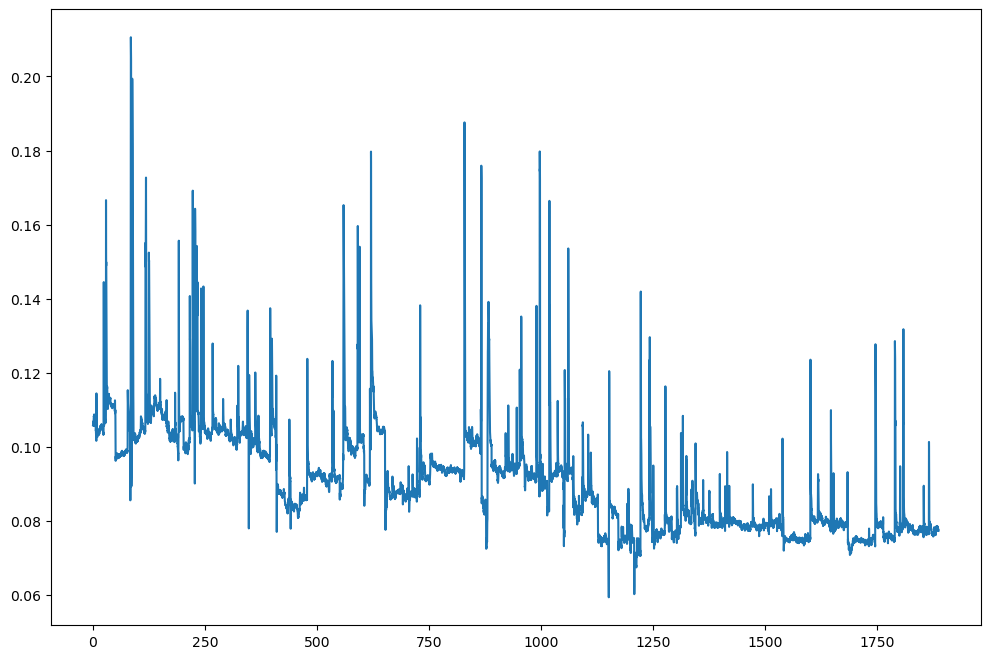

In [27]:
plt.plot(
    t,
    X[10]
)

In [28]:
scans[1][0].info['subject_info']

{'his_id': '1131-Child',
 'first_name': '1131-Child',
 'sex': 0 (FIFFV_SUBJ_SEX_UNKNOWN),
 'birthday': (2022, 3, 17),
 'their_id': '1131c'}

In [29]:
#When you initially check annotations, you will notice a large number of STOP annotations (12 in our case) that needed to be removed
scans[0][0].annotations

<Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>

In [30]:
#if annotations don't match across subjects, need to check the evt files for consistency, run a event conversion script for the data
for scan in scans:
    print(scan[0].info['subject_info']['their_id'],scan[0].annotations)


1145c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1131c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1219c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1200c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1256c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1203c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1143c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1112c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1113c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1138c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1245c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1263c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1188c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
1179c <Annotations | 24 segments: 1.0 (4), 128.0 (1

In [31]:
# rename events and set durations for all blocks

# if we can't load in the annotations right, we'll remove them from our list of scans
bads = []

for i, dscan in enumerate(scans):
    
    try:
        for scan in dscan:

            # rename the binary annotations with actual names
            scan.annotations.rename({
                '1.0': 'Block 1',
                '2.0': 'Block 2',
                '4.0': 'Block 3'})

            # remove any STOP annotations
            scan.annotations.delete(scan.annotations.description == '128.0')

            # set the durations based off the durations dictionary
            scan.annotations.set_durations(durations, verbose=True)
    
    except:
        bads.append(i)
        
for i in sorted(bads, reverse=True):
    del scans[i]

In [32]:
#stop durations are now removed and Blocks are now named correctly
scans[0][0].annotations

<Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>

In [33]:
scans[1][0].annotations.to_data_frame()

,onset,duration,description
0,2022-03-17 09:42:43.893,105.0,Block 1
1,2022-03-17 09:44:57.525,105.0,Block 1
2,2022-03-17 09:47:11.157,105.0,Block 1
3,2022-03-17 09:49:24.917,105.0,Block 1
4,2022-03-17 09:57:17.237,105.0,Block 2
5,2022-03-17 09:59:15.765,105.0,Block 2
6,2022-03-17 10:01:14.293,105.0,Block 2
7,2022-03-17 10:03:12.821,105.0,Block 2
8,2022-03-17 10:07:15.381,105.0,Block 3
9,2022-03-17 10:09:29.013,105.0,Block 3


In [34]:
from typing import Union

# function to do Continuous Wavelet Transform on a single signal
def mne_wavelet_transform(sig1: [mne.io.Raw, mne.Epochs], plot: bool = True,
                      chs: Union[str] = None):
    """
    Perform a continuous wavelet transform based off data in mne Raw object
    """
    
    # set time ##t0 = start time and dt = distance in time from t0. N is length
    t0 = sig1.times[0]
    dt = sig1.times[1] - t0
    N = len(sig1.times)
#     t = np.arange(0, N) * dt + t0
    t = sig1.times
    
    # define wavelet analysis parameters ## Clayton Add reference for parameters? 
    mother = wavelet.Morlet(6)
    s0 = 2 * dt # starting scale, in this case 2 * 0.128 s = 0.256 s
    dj = 1 / 12 # twelve sub-octaves per octaves
    J = 10 / dj # ten powers of 2 with dj sub-octaves
    
    if chs is None:
        chs = sig1.info['ch_names']
    
    for ch in chs:
        dat = np.squeeze(sig1.get_data(picks=[ch])) * 1e5
        
        # detrend and normalize the input data by its standard deviation
        p = np.polyfit(t - t0, dat, 1)
        dat_notrend = dat - np.polyval(p, t - t0)
        std = dat_notrend.std() # standard deviation
        var = std ** 2 # variance
        dat_norm = dat_notrend / std # normalized dataset
        
        alpha, _, _ = wavelet.ar1(dat) # lag-1 autocorrelation for red noise
        
        wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(
            dat_norm, dt, dj, s0, J, mother)
        iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std
    
        power = (np.abs(wave)) ** 2
        fft_power = np.abs(fft) ** 2
        period = 1 / freqs
        power /= scales[:, None] # optional according to Liu et al. (2007)
        
        # power significance test
        signif, fft_theor = wavelet.significance(
            1.0, dt, scales, 0, alpha,
            significance_level=0.95, 
            wavelet=mother)
        sig95 = np.ones([1, N]) * signif[:, None]
        sig95 = power / sig95
        
        # calculate global wavelet spectrum and determine its significance level
        glbl_power = power.mean(axis=1)
        dof = N - scales # correction for padding at edges
        glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                                significance_level=0.95, dof=dof,
                                                wavelet=mother)
        
        # calculate scale average and its significance level
        sel = find((period >= 10) & (period < 50))
        Cdelta = mother.cdelta
        scale_avg = (scales * np.ones((N, 1))).transpose()
        scale_avg = power / scale_avg # As in Torrence and Compo (1998) equation 24
        scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
        scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                                    significance_level=0.95,
                                                    dof=[scales[sel[0]],
                                                        scales[sel[-1]]],
                                                    wavelet=mother)
        
        if plot is True:
            
            title = f"{sig1.info['subject_info']['their_id']} Channel {ch} Continuous Wavelet Transform"
            label = ""
            units = 'Absorbance Units (AU)'
            
            # prepare the figure
            plt.close('all')
            plt.ioff()
            figprops = dict(figsize=(11, 8), dpi=72)
            fig = plt.figure(**figprops)
            
            # first sub-plot, the original time series
            ax = plt.axes([0.1, 0.75, 0.65, 0.2])
            ax.plot(t, dat, 'k', linewidth=1.5)
            ax.set_title('a) {}'.format(title))
            ax.set_ylabel(r'{} [{}]'.format(label, units))
            
            # second sub-plot, the normalized wavelet power spectrum and significance
            # level contour lines and cone of influence hatched area. Note that period
            # scale is logarithmic
            bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
            levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
            conmap = bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), 
                        extend='both', cmap=plt.cm.jet)
#             plt.colorbar(conmap)
            extent = [t.min(), t.max(), 0, max(period)]
            bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
                                  extent=extent)
            bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                                   t[:1] - dt, t[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')
            bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
            bx.set_ylabel('Frequency (Hz)')
            
            Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                                    np.ceil(np.log2(period.max())))
            
            bx.set_yticks(np.log2(Yticks))
            bx.set_yticklabels(1/Yticks)
            
            # third sub-plot, the global wavelet and Fourier power spectra and theoretical
            # noise spectra. Note that period scale is logarithmic
            cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
            cx.plot(glbl_signif, np.log2(period), 'k--')
            cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
            cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',
                    linewidth=1.)
            cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
            cx.set_title('c) Global Wavelet Spectrum')
            cx.set_xlabel(r'Power [({})^2]'.format(units))
            cx.set_xlim([0, glbl_power.max() + var])
            cx.set_ylim(np.log2([period.min(), period.max()]))
            cx.set_yticks(np.log2(Yticks))
            cx.set_yticklabels(1/Yticks)
            plt.setp(cx.get_yticklabels(), visible=False)
            
            # Fourth sub-plot, the scale averaged wavelet spectrum.
            dx = plt.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
            dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
            dx.plot(t, scale_avg, 'k-', linewidth=1.5)
            dx.set_title('d) {}--{} second scale-averaged power'.format(2, 8))
            dx.set_xlabel('Time (seconds)')
            dx.set_ylabel(r'Average variance [{}]'.format(units))
            ax.set_xlim([t.min(), t.max()])

            plt.show()
    
    return wave, scales, freqs, coi, fft, fftfreqs


# function to do wavelet coherence transform on 2 signals
def mne_wavelet_coherence_transform(sig1: [mne.io.Raw, mne.Epochs],
        sig2: [mne.io.Raw, mne.Epochs],
        plot: bool = True, fig_fname: str = None,
        chs: Union[str] = None):
    
    t0 = sig1.times[0]
    dt = sig1.times[1] - t0
    N = len(sig1.times)
#     t = np.arange(0, N) * dt + t0
    t = sig1.times
    
    # define wavelet analysis parameters
    mother = wavelet.Morlet(6)
    s0 = 2 * dt # starting scale, in this case 2 * 0.128 s = 0.256 s
    dj = 1 / 12 # twelve sub-octaves per octaves
    J = 10 / dj # ten powers of 2 with dj sub-octaves
    
    if chs is None:
        chs = sig1.info['ch_names']
        
    for ch in chs:
        dat1 = np.squeeze(sig1.get_data(picks=[ch]))
        dat2 = np.squeeze(sig2.get_data(picks=[ch]))
        
        if np.isnan(dat1).any():
            print("Dat 1 contains NaN values")
            raise ValueError
            
        if np.isnan(dat2).any():
            print("Dat 2 contains NaN values")
            raise ValueError
        
        # detrend and normalize the input data by its standard deviation
        p1 = np.polyfit(t - t0, dat1, 1)
        dat_notrend1 = dat1 - np.polyval(p1, t - t0)
        std1 = dat_notrend1.std() # standard deviation
        var1 = std1 ** 2 # variance
        dat_norm1 = dat_notrend1 / std1 # normalized dataset
        
        # detrend and normalize the input data by its standard deviation
        p2 = np.polyfit(t - t0, dat2, 1)
        dat_notrend2 = dat2 - np.polyval(p2, t - t0)
        std2 = dat_notrend2.std() # standard deviation
        var2 = std2 ** 2 # variance
        dat_norm2 = dat_notrend2 / std2 # normalized dataset
        
        WCT, aWCT, coi, freqs, sig95 = wavelet.wct(
            dat_norm1, dat_norm2,
            dt, dj=dj, s0=s0, J=J, sig=False,
            significance_level=0.95, wavelet='morlet',
            normalize=True)
        
        period = 1 / freqs
        
        if plot is True:
            
            title = f"{sig1.info['subject_info']['their_id']} / {sig2.info['subject_info']['their_id']} Channel {ch} Wavelet Coherence Transform"
            label = f"{sig1.info['subject_info']['their_id']} {sig2.info['subject_info']['their_id']} {ch}"
            units = 'Absorbance Units (AU)'
            
            # prepare the figure
            plt.close('all')
            plt.ioff()
            figprops = dict(figsize=(11, 8), dpi=72)
            fig = plt.figure(**figprops)
            
            # first sub-plot, the normalized wavelet power spectrum and significance
            # level contour lines and cone of influence hatched area. Note that period
            # scale is logarithmic
            ax = plt.axes([0.1, 0.37, 0.65, 0.28])
#             levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
            levels = list(np.arange(0.1, 1, step=0.1))
            conmap = ax.contourf(t, np.log2(period), WCT, levels, 
                        extend='both', cmap=plt.cm.jet)
            plt.colorbar(conmap)
            extent = [t.min(), t.max(), 0, max(period)]
#             ax.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#                                   extent=extent)
            ax.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                                   t[:1] - dt, t[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')
            ax.set_title('b) {} Wavelet Coherence Spectrum ({})'.format(label, mother.name))
            ax.set_ylabel('Frequency (Hz)')
            
            Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                                    np.ceil(np.log2(period.max())))
            
            ax.set_yticks(np.log2(Yticks))
            ax.set_yticklabels(1/Yticks)
            ax.set_xlim([t.min(), t.max()])
            ax.set_ylim(np.log2([period.min(), period.max()]))
            
            if fig_fname is None:
                plt.show()
            else:
                plt.savefig(fig_fname)
            
    return WCT, aWCT, coi, freqs, sig95 

In [35]:
scans[1][0].ch_names

['S1_D1 760',
 'S1_D1 850',
 'S2_D1 760',
 'S2_D1 850',
 'S2_D2 760',
 'S2_D2 850',
 'S3_D2 760',
 'S3_D2 850',
 'S4_D2 760',
 'S4_D2 850',
 'S5_D3 760',
 'S5_D3 850',
 'S6_D3 760',
 'S6_D3 850',
 'S7_D3 760',
 'S7_D3 850',
 'S7_D4 760',
 'S7_D4 850',
 'S8_D4 760',
 'S8_D4 850']

Using matplotlib as 2D backend.


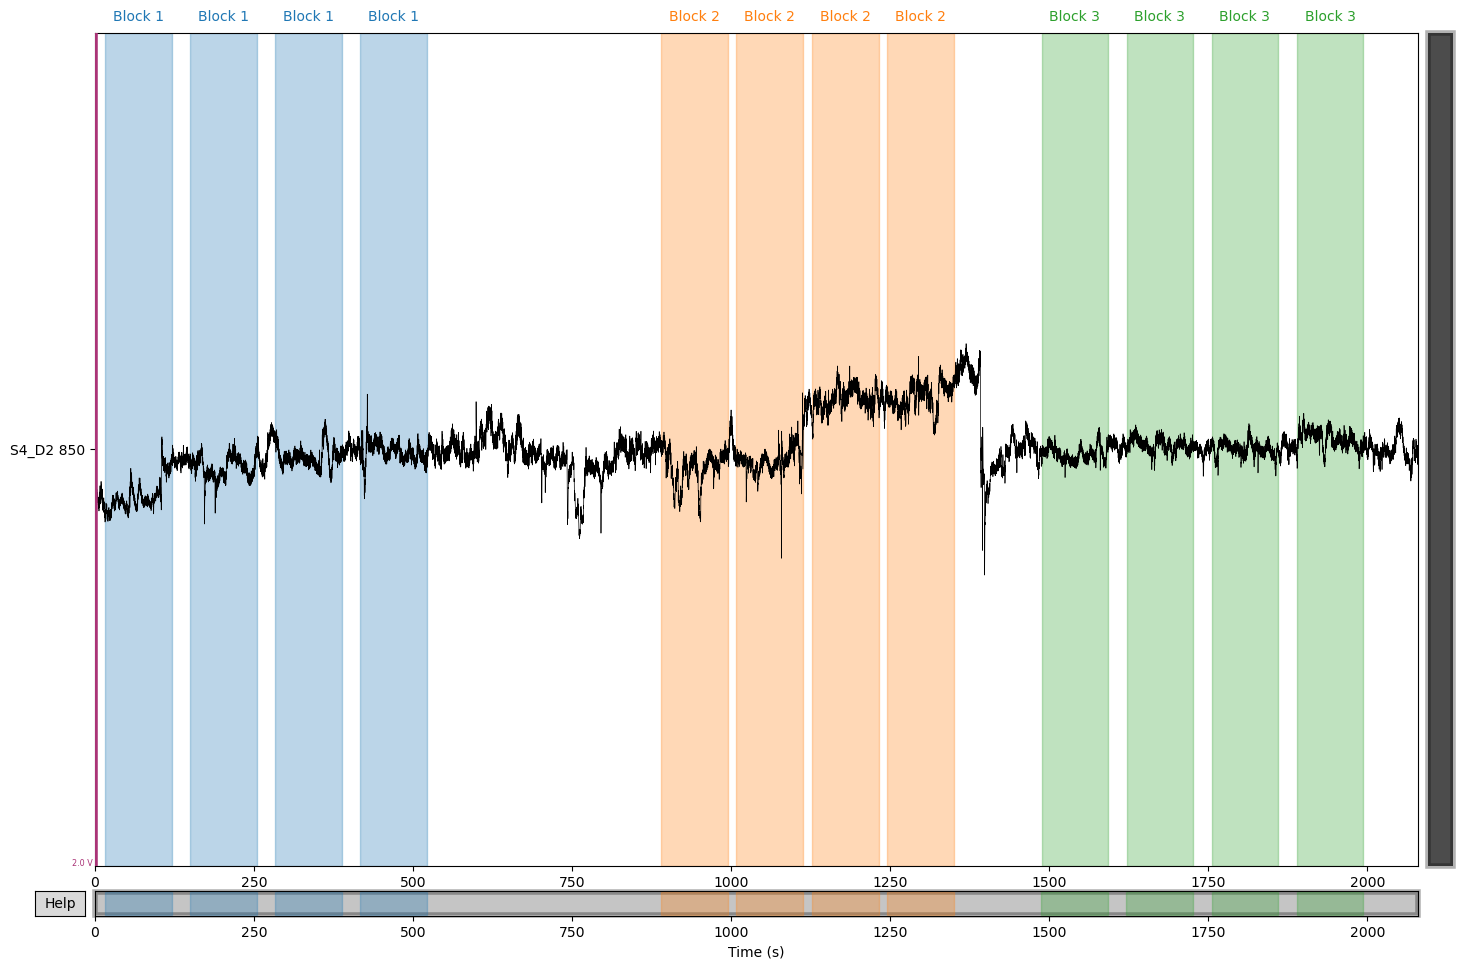

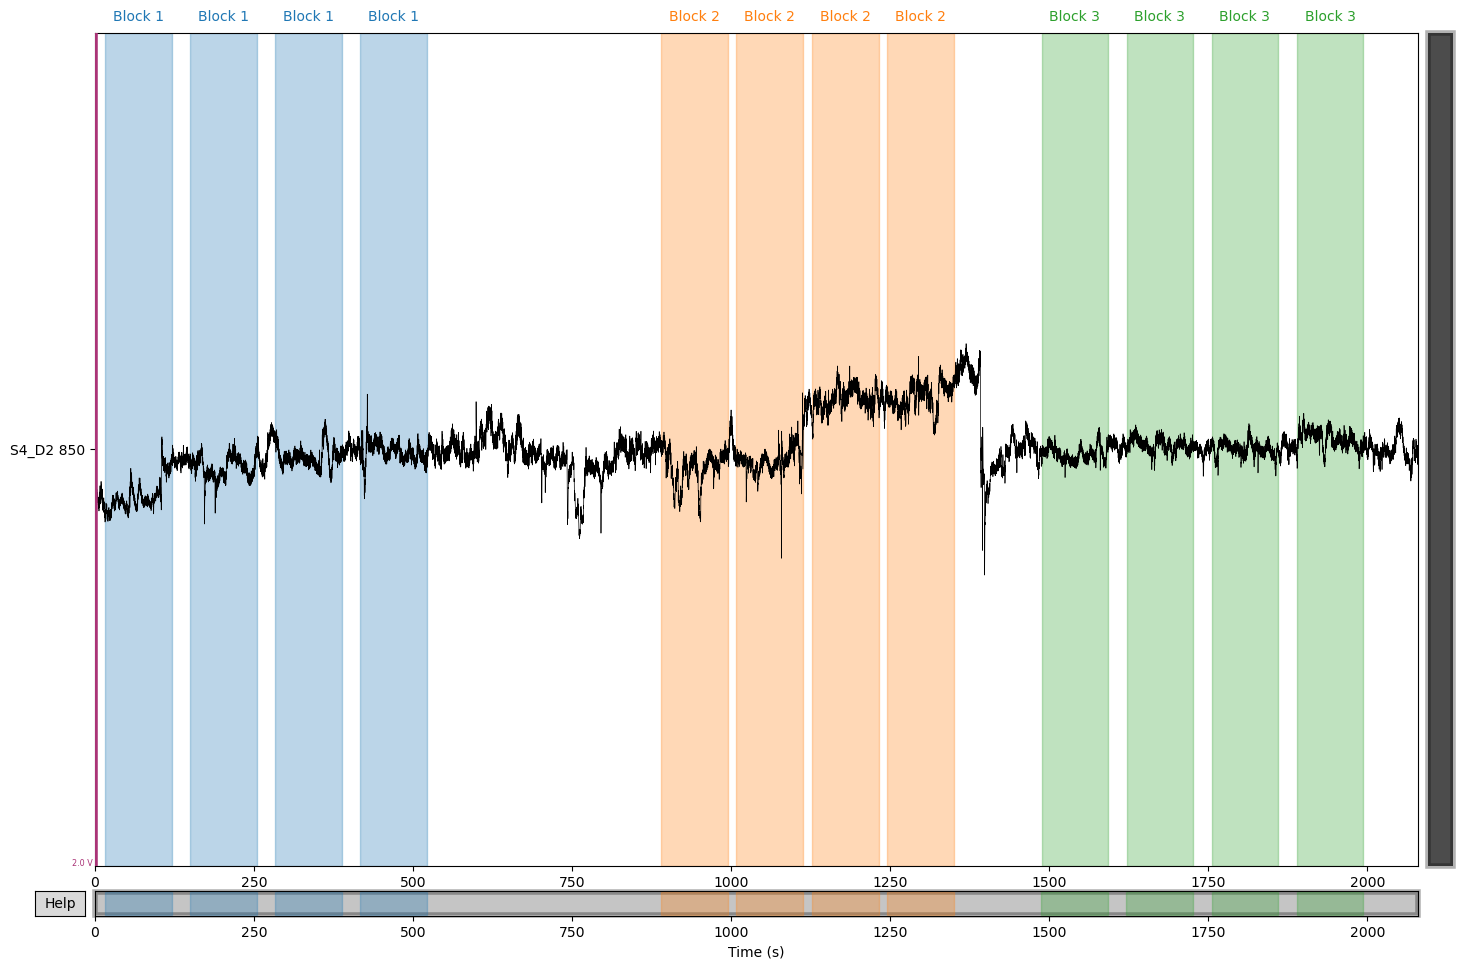

In [36]:
# example Block plot for 3000 seconds
scans[1][0].copy().pick(['S4_D2 850']).plot(duration=3000, scalings=1)

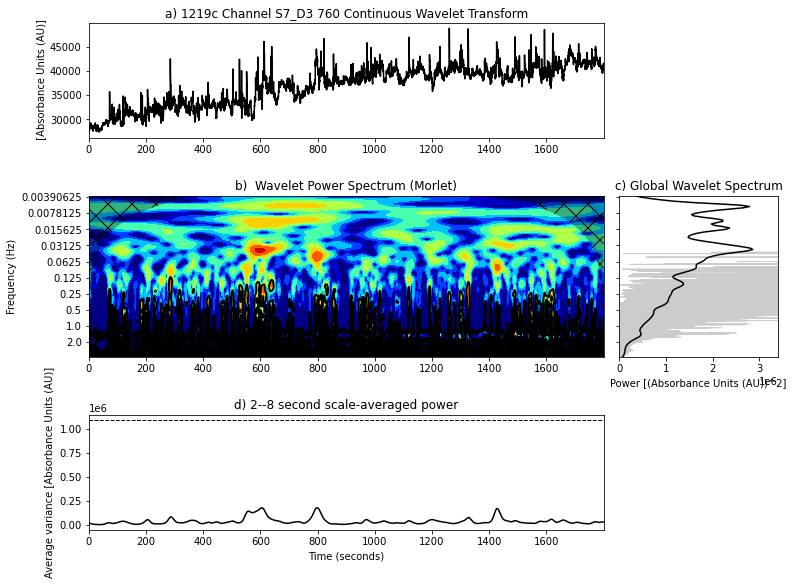

In [37]:
# example wavelet transform for 1800 seconds
wave, scales, freqs, coi, fft, fftfreqs = mne_wavelet_transform(
    scans[2][0].copy().crop(tmax=1800),
    plot=True,
    chs=['S7_D3 760']
)

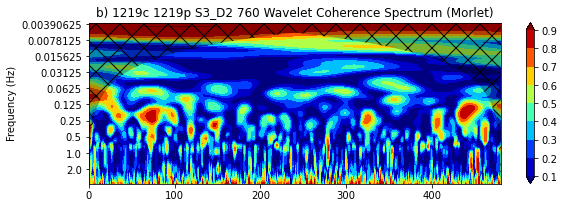

In [38]:
# example coherence transform from a real dyad with 400 seconds

WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    scans[2][0].copy().pick(['S3_D2 760']).crop(tmax=480),
    scans[2][1].copy().pick(['S3_D2 760']).crop(tmax=480),
    plot=True)

# Preprocessing Step

Now that data are loaded in and events are correctly distinct, we iterate through each dyad and each individual scan to apply LCBD-standard preprocessing functions. 
- Convert to Optical Density
- Record Scalp-Coupling Index and Mark Channels < 0.5
- Temporal Derivative Distribution Repair
- Beer Lambert Law to Convert to Haemoglobin
- Bandpass Filter 0.01-0.5 Hz

and append those dyads to a list of preprocessed scans. 

In [40]:
# make a list where the preprocessed scans will go
pps = []

# for each dyad scan in scans
for dscan in scans:

    ppdscan = [] # make a list for the preprocessed dyad's scans
    
    # individually preprocess each subject in dyad
    for scan in dscan:
        
        # convert to optical density
        raw_od = mne.preprocessing.nirs.optical_density(scan)
        print(raw_od.info['subject_info']['their_id'])

        # scalp coupling index
        sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
        raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.5))
        
        # linear detrend, par example
#         raw.data[:] = scipy.signal.detrend(raw.get_data(), axis=-1, fit='linear')
        #bad channel labelling
        if len(raw_od.info['bads']) > 0:
            print("--->>>>Bad channels in subject", raw_od.info['subject_info']['their_id'], ":", raw_od.info['bads'])
        
        # temporal derivative distribution repair (motion attempt)
        tddr_od = mne.preprocessing.nirs.tddr(raw_od)
#         print("tddr")
#         tddr_od.plot(
#             n_channels=len(tddr_od.ch_names),
#             scalings=0.1,
#             duration=100,
#             show_scrollbars=False)
        
        # savgol filter (linear polynomial smoothing)
#         sav_od = raw_od.savgol_filter(0.5)
#         print("savgol filtering")
#         sav_od.plot(
#             n_channels=len(sav_od.ch_names),
#             scalings=0.1,
#             duration=100,
#             show_scrollbars=False)

        #bandpass filtering
        bp_od = tddr_od.filter(0.01, 0.5)
#         print("bandpass")
#         bp_od.plot(
#             n_channels=len(bp_od.ch_names),
#             duration=100,
#             scalings=0.1,
#             show_scrollbars=False)
    
        # haemoglobin conversion
        haemo = mne.preprocessing.nirs.beer_lambert_law(bp_od, ppf=0.1)
#         print("haemo")
#         haemo.plot(
#             n_channels=len(haemo.ch_names),
#             duration=100,
#             scalings=0.0001,
#             show_scrollbars=False)

#         print("PSD")
#         haemo_lp.plot_psd(average=True)
        
        ppdscan.append(haemo)
        
    pps.append(ppdscan)

Reading 0 ... 14738  =      0.000 ...  1886.464 secs...
1145c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14738  =      0.000 ...  1886.464 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1145p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 16246  =      0.000 ...  2079.488 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1131c
--->>>>Bad channels in subject 1131c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 16246  =      0.000 ...  2079.488 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1131p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15357  =      0.000 ...  1965.696 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1219c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15357  =      0.000 ...  1965.696 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1219p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15412  =      0.000 ...  1972.736 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1200c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15412  =      0.000 ...  1972.736 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1200p
--->>>>Bad channels in subject 1200p : ['S1_D1 760', 'S1_D1 850', 'S6_D3 760', 'S6_D3 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15516  =      0.000 ...  1986.048 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1256c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15516  =      0.000 ...  1986.048 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1256p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 17643  =      0.000 ...  2258.304 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1203c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 17643  =      0.000 ...  2258.304 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1203p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14844  =      0.000 ...  1900.032 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1143c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14844  =      0.000 ...  1900.032 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1143p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14498  =      0.000 ...  1855.744 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1112c
--->>>>Bad channels in subject 1112c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14498  =      0.000 ...  1855.744 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1112p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15217  =      0.000 ...  1947.776 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1113c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15217  =      0.000 ...  1947.776 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1113p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14154  =      0.000 ...  1811.712 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1138c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14154  =      0.000 ...  1811.712 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1138p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15224  =      0.000 ...  1948.672 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1245c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15224  =      0.000 ...  1948.672 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1245p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15890  =      0.000 ...  2033.920 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1263c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15890  =      0.000 ...  2033.920 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1263p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14600  =      0.000 ...  1868.800 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1188c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14600  =      0.000 ...  1868.800 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1188p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15084  =      0.000 ...  1930.752 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1179c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15084  =      0.000 ...  1930.752 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1179p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14809  =      0.000 ...  1895.552 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1102c
--->>>>Bad channels in subject 1102c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14809  =      0.000 ...  1895.552 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1102p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15437  =      0.000 ...  1975.936 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1133c
--->>>>Bad channels in subject 1133c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15437  =      0.000 ...  1975.936 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1133p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14727  =      0.000 ...  1885.056 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1268c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14727  =      0.000 ...  1885.056 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1268p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14000  =      0.000 ...  1792.000 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1137c
--->>>>Bad channels in subject 1137c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14000  =      0.000 ...  1792.000 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1137p
--->>>>Bad channels in subject 1137p : ['S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14346  =      0.000 ...  1836.288 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1127c
--->>>>Bad channels in subject 1127c : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14346  =      0.000 ...  1836.288 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1127p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15211  =      0.000 ...  1947.008 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1204c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15211  =      0.000 ...  1947.008 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1204p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15218  =      0.000 ...  1947.904 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1253c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15218  =      0.000 ...  1947.904 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1253p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 12557  =      0.000 ...  1607.296 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1209c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 12557  =      0.000 ...  1607.296 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1209p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14539  =      0.000 ...  1860.992 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1172c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14539  =      0.000 ...  1860.992 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1172p
--->>>>Bad channels in subject 1172p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S4_D2 760', 'S4_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15366  =      0.000 ...  1966.848 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1175c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15366  =      0.000 ...  1966.848 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1175p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14326  =      0.000 ...  1833.728 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1194c
--->>>>Bad channels in subject 1194c : ['S2_D1 760', 'S2_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14326  =      0.000 ...  1833.728 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1194p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15870  =      0.000 ...  2031.360 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1134c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15870  =      0.000 ...  2031.360 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1134p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14664  =      0.000 ...  1876.992 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1116c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14664  =      0.000 ...  1876.992 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1116p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15985  =      0.000 ...  2046.080 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1228c
--->>>>Bad channels in subject 1228c : ['S3_D2 760', 'S3_D2 850', 'S6_D3 760', 'S6_D3 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15985  =      0.000 ...  2046.080 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1228p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14850  =      0.000 ...  1900.800 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1129c
--->>>>Bad channels in subject 1129c : ['S2_D2 760', 'S2_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14850  =      0.000 ...  1900.800 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1129p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14942  =      0.000 ...  1912.576 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1213c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14942  =      0.000 ...  1912.576 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1213p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14870  =      0.000 ...  1903.360 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1124c
--->>>>Bad channels in subject 1124c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14870  =      0.000 ...  1903.360 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1124p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15261  =      0.000 ...  1953.408 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1156c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15261  =      0.000 ...  1953.408 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1156p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15444  =      0.000 ...  1976.832 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1243c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15444  =      0.000 ...  1976.832 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1243p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15434  =      0.000 ...  1975.552 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1251c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15434  =      0.000 ...  1975.552 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1251p
--->>>>Bad channels in subject 1251p : ['S1_D1 760', 'S1_D1 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15076  =      0.000 ...  1929.728 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1154c
--->>>>Bad channels in subject 1154c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15076  =      0.000 ...  1929.728 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1154p
--->>>>Bad channels in subject 1154p : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14134  =      0.000 ...  1809.152 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1148c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14134  =      0.000 ...  1809.152 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1148p
--->>>>Bad channels in subject 1148p : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14555  =      0.000 ...  1863.040 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1147c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14555  =      0.000 ...  1863.040 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1147p
--->>>>Bad channels in subject 1147p : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14533  =      0.000 ...  1860.224 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1139c
--->>>>Bad channels in subject 1139c : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14533  =      0.000 ...  1860.224 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1139p
--->>>>Bad channels in subject 1139p : ['S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15700  =      0.000 ...  2009.600 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1114c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15700  =      0.000 ...  2009.600 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1114p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15325  =      0.000 ...  1961.600 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1254c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15325  =      0.000 ...  1961.600 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1254p
--->>>>Bad channels in subject 1254p : ['S6_D3 760', 'S6_D3 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15992  =      0.000 ...  2046.976 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1252c
--->>>>Bad channels in subject 1252c : ['S3_D2 760', 'S3_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15992  =      0.000 ...  2046.976 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1252p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15419  =      0.000 ...  1973.632 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1190c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15419  =      0.000 ...  1973.632 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1190p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14561  =      0.000 ...  1863.808 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1122c
--->>>>Bad channels in subject 1122c : ['S7_D4 760', 'S7_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14561  =      0.000 ...  1863.808 secs...


/var/folders/bj/k48c5pg95p3f66x8j20kgs2sf68j1h/T/ipykernel_17686/1791202149.py:13: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(scan)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1122p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14923  =      0.000 ...  1910.144 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1248c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14923  =      0.000 ...  1910.144 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1248p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 16976  =      0.000 ...  2172.928 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1168c
--->>>>Bad channels in subject 1168c : ['S2_D1 760', 'S2_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 16976  =      0.000 ...  2172.928 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1168p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15080  =      0.000 ...  1930.240 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1223c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15080  =      0.000 ...  1930.240 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1223p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14994  =      0.000 ...  1919.232 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1222c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14994  =      0.000 ...  1919.232 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1222p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15497  =      0.000 ...  1983.616 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1232c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15497  =      0.000 ...  1983.616 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1232p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15597  =      0.000 ...  1996.416 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1185c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15597  =      0.000 ...  1996.416 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1185p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15038  =      0.000 ...  1924.864 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1176c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15038  =      0.000 ...  1924.864 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1176p
--->>>>Bad channels in subject 1176p : ['S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850', 'S4_D2 760', 'S4_D2 850', 'S7_D4 760', 'S7_D4 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15387  =      0.000 ...  1969.536 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1214c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15387  =      0.000 ...  1969.536 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1214p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14692  =      0.000 ...  1880.576 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1130c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14692  =      0.000 ...  1880.576 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1130p
--->>>>Bad channels in subject 1130p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850', 'S4_D2 760', 'S4_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 16546  =      0.000 ...  2117.888 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1165c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 16546  =      0.000 ...  2117.888 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1165p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14821  =      0.000 ...  1897.088 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1242c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14821  =      0.000 ...  1897.088 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1242p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15339  =      0.000 ...  1963.392 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1160c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15339  =      0.000 ...  1963.392 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1160p
--->>>>Bad channels in subject 1160p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 16889  =      0.000 ...  2161.792 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1109c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 16889  =      0.000 ...  2161.792 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1109p
--->>>>Bad channels in subject 1109p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S7_D3 760', 'S7_D3 850', 'S7_D4 760', 'S7_D4 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 16020  =      0.000 ...  2050.560 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1151c
--->>>>Bad channels in subject 1151c : ['S7_D3 760', 'S7_D3 850', 'S7_D4 760', 'S7_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 16020  =      0.000 ...  2050.560 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1151p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15700  =      0.000 ...  2009.600 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1207c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15700  =      0.000 ...  2009.600 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1207p
--->>>>Bad channels in subject 1207p : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14640  =      0.000 ...  1873.920 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1258c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14640  =      0.000 ...  1873.920 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1258p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15527  =      0.000 ...  1987.456 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1178c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15527  =      0.000 ...  1987.456 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1178p
--->>>>Bad channels in subject 1178p : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15912  =      0.000 ...  2036.736 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1177c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15912  =      0.000 ...  2036.736 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1177p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15961  =      0.000 ...  2043.008 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1110c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15961  =      0.000 ...  2043.008 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1110p
--->>>>Bad channels in subject 1110p : ['S1_D1 760', 'S1_D1 850', 'S3_D2 760', 'S3_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14851  =      0.000 ...  1900.928 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1159c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14851  =      0.000 ...  1900.928 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1159p
--->>>>Bad channels in subject 1159p : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14749  =      0.000 ...  1887.872 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1266c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14749  =      0.000 ...  1887.872 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1266p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14539  =      0.000 ...  1860.992 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1244c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14539  =      0.000 ...  1860.992 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1244p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14888  =      0.000 ...  1905.664 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1117c
--->>>>Bad channels in subject 1117c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14888  =      0.000 ...  1905.664 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1117p
--->>>>Bad channels in subject 1117p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15752  =      0.000 ...  2016.256 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1220c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15752  =      0.000 ...  2016.256 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1220p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15071  =      0.000 ...  1929.088 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1144c
--->>>>Bad channels in subject 1144c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15071  =      0.000 ...  1929.088 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1144p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14801  =      0.000 ...  1894.528 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1146c
--->>>>Bad channels in subject 1146c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14801  =      0.000 ...  1894.528 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1146p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 16941  =      0.000 ...  2168.448 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1240c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 16941  =      0.000 ...  2168.448 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1240p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15069  =      0.000 ...  1928.832 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1205c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15069  =      0.000 ...  1928.832 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1205p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15844  =      0.000 ...  2028.032 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1187c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15844  =      0.000 ...  2028.032 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1187p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15431  =      0.000 ...  1975.168 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1225c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15431  =      0.000 ...  1975.168 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1225p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 16162  =      0.000 ...  2068.736 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1216c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 16162  =      0.000 ...  2068.736 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1216p
--->>>>Bad channels in subject 1216p : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14943  =      0.000 ...  1912.704 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1195c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14943  =      0.000 ...  1912.704 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1195p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15047  =      0.000 ...  1926.016 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1227c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15047  =      0.000 ...  1926.016 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1227p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14391  =      0.000 ...  1842.048 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1126c
--->>>>Bad channels in subject 1126c : ['S2_D2 760', 'S2_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14391  =      0.000 ...  1842.048 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1126p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14399  =      0.000 ...  1843.072 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1226c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14399  =      0.000 ...  1843.072 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1226p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14991  =      0.000 ...  1918.848 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1231c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14991  =      0.000 ...  1918.848 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1231p
--->>>>Bad channels in subject 1231p : ['S3_D2 760', 'S3_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14539  =      0.000 ...  1860.992 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1149c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14539  =      0.000 ...  1860.992 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1149p
--->>>>Bad channels in subject 1149p : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14937  =      0.000 ...  1911.936 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1236c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14937  =      0.000 ...  1911.936 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1236p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14850  =      0.000 ...  1900.800 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1121c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14850  =      0.000 ...  1900.800 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1121p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15079  =      0.000 ...  1930.112 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1264c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15079  =      0.000 ...  1930.112 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1264p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15330  =      0.000 ...  1962.240 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1255c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15330  =      0.000 ...  1962.240 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1255p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14707  =      0.000 ...  1882.496 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1170c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14707  =      0.000 ...  1882.496 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1170p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15544  =      0.000 ...  1989.632 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1103c
--->>>>Bad channels in subject 1103c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15544  =      0.000 ...  1989.632 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1103p
--->>>>Bad channels in subject 1103p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850', 'S7_D3 760', 'S7_D3 850', 'S7_D4 760', 'S7_D4 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14000  =      0.000 ...  1792.000 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1189c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14000  =      0.000 ...  1792.000 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1189p
--->>>>Bad channels in subject 1189p : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14333  =      0.000 ...  1834.624 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1174c
--->>>>Bad channels in subject 1174c : ['S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14333  =      0.000 ...  1834.624 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1174p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15132  =      0.000 ...  1936.896 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1235c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15132  =      0.000 ...  1936.896 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1235p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14091  =      0.000 ...  1803.648 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1164c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14091  =      0.000 ...  1803.648 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1164p
--->>>>Bad channels in subject 1164p : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14629  =      0.000 ...  1872.512 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1247c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14629  =      0.000 ...  1872.512 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1247p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14357  =      0.000 ...  1837.696 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1125c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14357  =      0.000 ...  1837.696 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1125p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 17286  =      0.000 ...  2212.608 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1211c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 17286  =      0.000 ...  2212.608 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1211p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 16098  =      0.000 ...  2060.544 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1234c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 16098  =      0.000 ...  2060.544 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1234p
--->>>>Bad channels in subject 1234p : ['S1_D1 760', 'S1_D1 850', 'S2_D2 760', 'S2_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14574  =      0.000 ...  1865.472 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1155c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14574  =      0.000 ...  1865.472 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1155p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14716  =      0.000 ...  1883.648 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1246c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14716  =      0.000 ...  1883.648 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1246p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15119  =      0.000 ...  1935.232 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1141c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15119  =      0.000 ...  1935.232 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1141p
--->>>>Bad channels in subject 1141p : ['S6_D3 760', 'S6_D3 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15524  =      0.000 ...  1987.072 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1115c
--->>>>Bad channels in subject 1115c : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850', 'S4_D2 760', 'S4_D2 850', 'S5_D3 760', 'S5_D3 850', 'S6_D3 760', 'S6_D3 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15524  =      0.000 ...  1987.072 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1115p
--->>>>Bad channels in subject 1115p : ['S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15369  =      0.000 ...  1967.232 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1186c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15369  =      0.000 ...  1967.232 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1186p
--->>>>Bad channels in subject 1186p : ['S2_D2 760', 'S2_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15670  =      0.000 ...  2005.760 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1269c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15670  =      0.000 ...  2005.760 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1269p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15612  =      0.000 ...  1998.336 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1184c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15612  =      0.000 ...  1998.336 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1184p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 16003  =      0.000 ...  2048.384 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1202c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 16003  =      0.000 ...  2048.384 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1202p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15396  =      0.000 ...  1970.688 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1229c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15396  =      0.000 ...  1970.688 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1229p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15931  =      0.000 ...  2039.168 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1265c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15931  =      0.000 ...  2039.168 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1265p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15254  =      0.000 ...  1952.512 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1162c
--->>>>Bad channels in subject 1162c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15254  =      0.000 ...  1952.512 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1162p
--->>>>Bad channels in subject 1162p : ['S7_D3 760', 'S7_D3 850', 'S7_D4 760', 'S7_D4 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14821  =      0.000 ...  1897.088 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1173c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14821  =      0.000 ...  1897.088 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1173p
--->>>>Bad channels in subject 1173p : ['S7_D3 760', 'S7_D3 850', 'S7_D4 760', 'S7_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15840  =      0.000 ...  2027.520 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1167c
--->>>>Bad channels in subject 1167c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15840  =      0.000 ...  2027.520 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1167p
--->>>>Bad channels in subject 1167p : ['S1_D1 760', 'S1_D1 850', 'S7_D4 760', 'S7_D4 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15718  =      0.000 ...  2011.904 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1267c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15718  =      0.000 ...  2011.904 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1267p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15813  =      0.000 ...  2024.064 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1270c
--->>>>Bad channels in subject 1270c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15813  =      0.000 ...  2024.064 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1270p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15507  =      0.000 ...  1984.896 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1193c
--->>>>Bad channels in subject 1193c : ['S1_D1 760', 'S1_D1 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15507  =      0.000 ...  1984.896 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1193p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 16728  =      0.000 ...  2141.184 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1182c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 16728  =      0.000 ...  2141.184 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1182p
--->>>>Bad channels in subject 1182p : ['S3_D2 760', 'S3_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14796  =      0.000 ...  1893.888 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1180c
--->>>>Bad channels in subject 1180c : ['S1_D1 760', 'S1_D1 850', 'S8_D4 760', 'S8_D4 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 14796  =      0.000 ...  1893.888 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1180p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15403  =      0.000 ...  1971.584 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1104c
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15403  =      0.000 ...  1971.584 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1104p
--->>>>Bad channels in subject 1104p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15447  =      0.000 ...  1977.216 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1250c
--->>>>Bad channels in subject 1250c : ['S6_D3 760', 'S6_D3 850']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)

Reading 0 ... 15447  =      0.000 ...  1977.216 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1250p
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


In [42]:
#Creating a dictionary variable to store bad channels for later
bad_channels_dict = {}

for dscan in pps:
    
    for scan in dscan:
        
        bads = scan.info['bads']
        bad_channels_dict[scan.info['subject_info']['their_id']] = \
            bads
        

In [45]:
bad_channels_dict['1222c']

[]

In [ ]:
pps[1][0].info['subject_info']

{'his_id': '1130-Child',
 'first_name': '1130-Child',
 'sex': 0 (FIFFV_SUBJ_SEX_UNKNOWN),
 'birthday': (2022, 3, 22),
 'their_id': '1130c'}

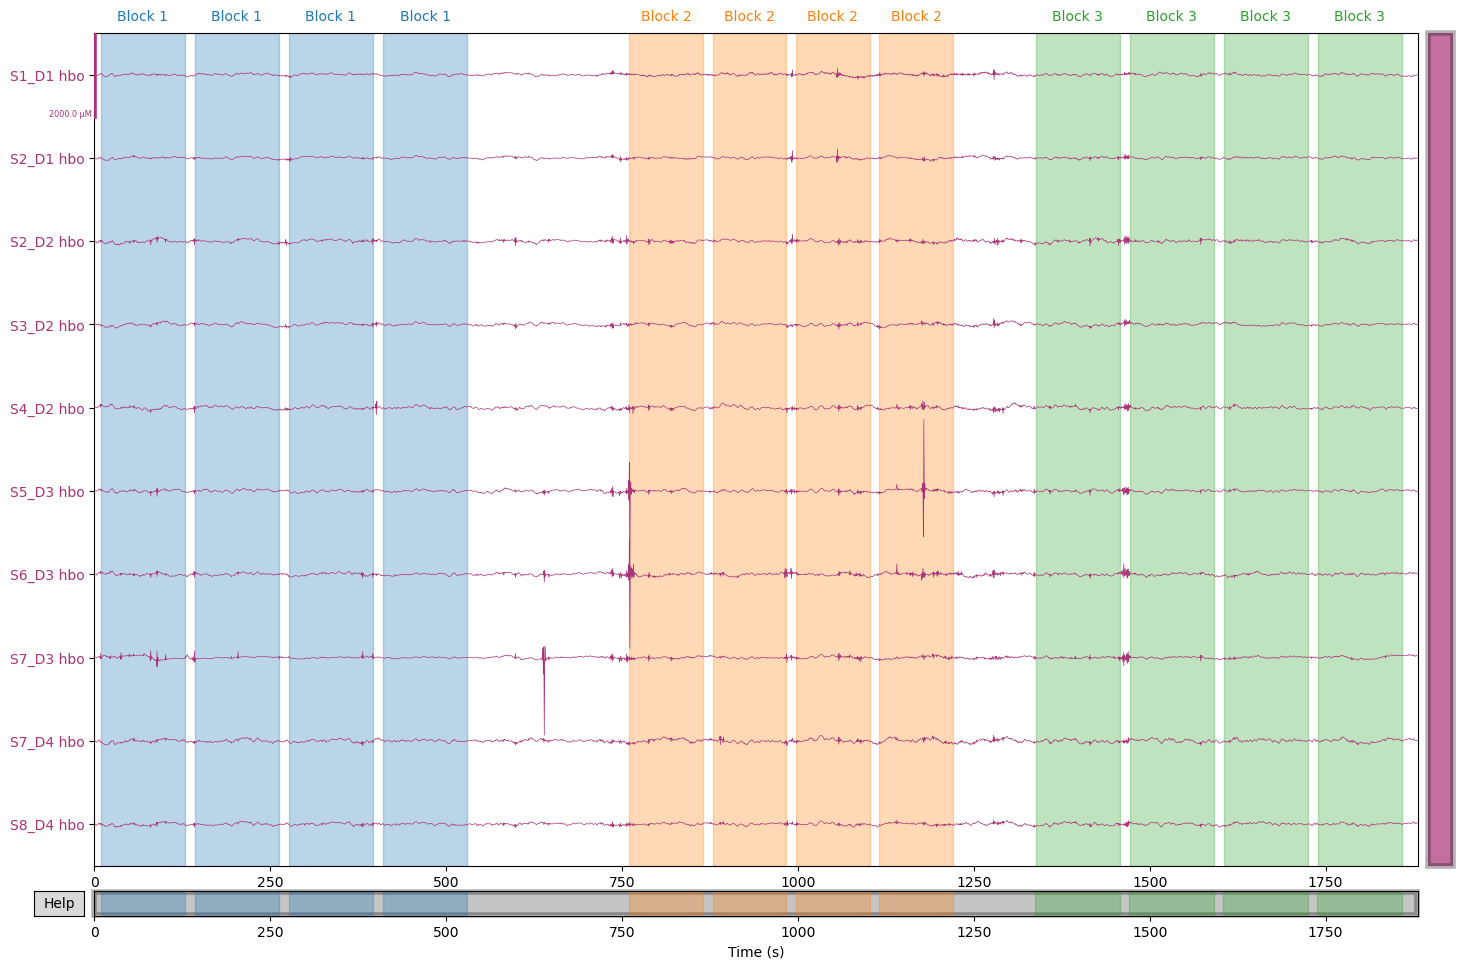

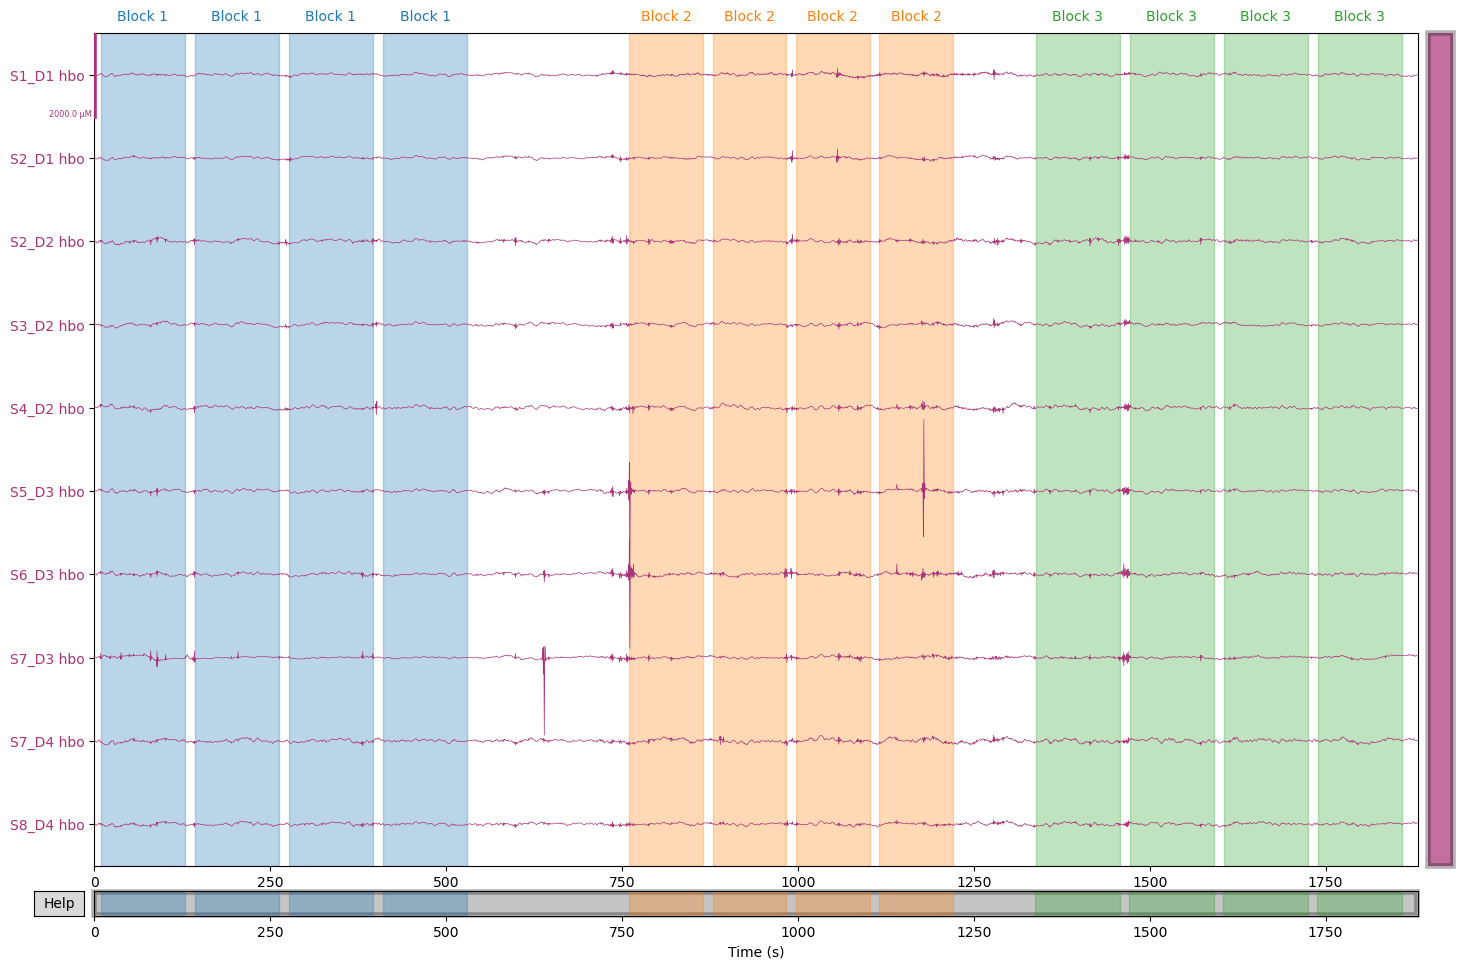

In [ ]:
# example plot for 3000 seconds
pps[1][0].copy().pick(['hbo']).plot(duration=3000, scalings=0.001)

In [ ]:
sampling_rate = pps[0][0].info['sfreq']
print(sampling_rate)

7.8125


In [ ]:
# make a dictionary where all of the epoch'd data will go
epoch_df = {}

# loop over the dyads in the preprocessed list
for dscan in pps:
    
    # February 9th 2023
    # Clayton update to prune subjects who have
    # >= 10 channels dropped from the SCI function during preprocessing
    max_bad = max([len(scan.info['bads']) for scan in dscan])
    # whichever number is higher ^, num. of channels dropped in
    # either parent or child
    
    if max_bad >= 10:
        for scan in dscan:
            sub_num = scan.info['subject_info']['their_id']
            print("Subject {} was dropped from further analysis.".format(sub_num))
        
        continue # skip this dyad
        # if max_bad is greater than or equal to 10
    
    # for each scan in the dyad
    for scan in dscan:
    
        # set their location in the epoch df to a dictionary
        epoch_df[scan.info['subject_info']['their_id']] = {}
    
#        for i, ROI in enumerate(ROIs.keys()):

        # loop over ROIs (channels here)
        for i, ROI in enumerate([ch for ch in scan.info['ch_names'] if "hbo" in ch]):
            
            epoch_df[scan.info['subject_info']['their_id']][ROI] = []
        
            # get their events and set block durations
            events, event_dict = mne.events_from_annotations(dscan[0], verbose=False)
            reject_criteria = dict(hbo=200e-6)
            tmin, puzzletmax, playtmax = -5, 105, 105
            
            # use the mne.Epochs function / object to generate epochs
            preplay_epochs = mne.Epochs(
                scan, # the scan object
                events, # its events
#                 picks=ROIs[ROI],
                picks=[ROI], # the channels
                event_id={list(event_dict.keys())[0]: list(event_dict.values())[0]}, # the first event key
                tmin=tmin, # epoch relative start time
                tmax=playtmax, # epoch relative end time
                baseline= (None, 0), # baseline window to subtract
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1, # linear detrend
                verbose=False, 
                preload=False, # don't actually load it yet (saves memory)
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['their_id']][ROI].append(preplay_epochs)
            
            puzzle_epochs = mne.Epochs(
                scan,
                events,
#                 picks=ROIs[ROI],
                picks=[ROI],
                event_id={list(event_dict.keys())[1]: list(event_dict.values())[1]},
                tmin=tmin,
                tmax=puzzletmax,
                baseline= (None, 0),
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1,
                verbose=False,
                preload=False,
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['their_id']][ROI].append(puzzle_epochs)
            
            postplay_epochs = mne.Epochs(
                scan,
                events,
#                 picks=ROIs[ROI],
                picks=[ROI],
                event_id={list(event_dict.keys())[2]: list(event_dict.values())[2]},
                tmin=tmin,
                tmax=playtmax,
                baseline=(None, 0),
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1,
                verbose=False,
                preload=False,
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['their_id']][ROI].append(postplay_epochs)

Subject 1130c was dropped from further analysis.
Subject 1130p was dropped from further analysis.
Subject 1115c was dropped from further analysis.
Subject 1115p was dropped from further analysis.
Subject 1103c was dropped from further analysis.
Subject 1103p was dropped from further analysis.
Subject 1176c was dropped from further analysis.
Subject 1176p was dropped from further analysis.
Subject 1109c was dropped from further analysis.
Subject 1109p was dropped from further analysis.


In [ ]:
# here is the way to access information in the epoch dictionary

In [ ]:
#Will telll you how many dyads are retaining for further analyses
len([sub for sub in epoch_df.keys() if "c" in sub])

109

In [ ]:
# a single subject 
epoch_df['1222c']

{'S1_D1 hbo': [<Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 2': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 3': 4>],
 'S2_D1 hbo': [<Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 2': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 3': 4>],
 'S2_D2 hbo': [<Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~1

In [ ]:
# a specific channel from the subject
epoch_df['1222c']['S1_D1 hbo']

[<Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
  'Block 1': 4>,
 <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
  'Block 2': 4>,
 <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
  'Block 3': 4>]

In [ ]:
# a specific block at that subject / channel, in this case the first (0) is pre-play
epoch_df['1222c']['S1_D1 hbo'][2]

Number of events,4
Events,Block 3: 4
Time range,-4.992 – 104.960 sec
Baseline,-4.992 – 0.000 sec


In [ ]:
# a specific iteration/trial of that block at that subject / channel, in this case the first (0) is pre-play, we look at the 4th (3) iteration of the block
epoch_df['1222c']['S1_D1 hbo'][0][3]

Number of events,1
Events,Block 1: 1
Time range,-4.992 – 104.960 sec
Baseline,-4.992 – 0.000 sec


In [ ]:
event_dict

{'Block 1': 1, 'Block 2': 2, 'Block 3': 3}

Using data from preloaded Raw for 1 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 860 original time points ...
0 bad epochs dropped


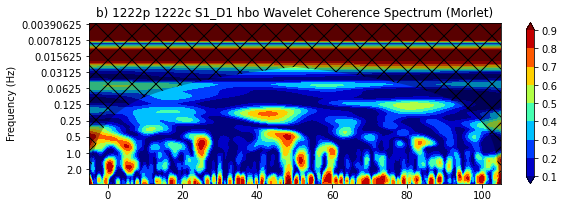

Using data from preloaded Raw for 1 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 860 original time points ...
0 bad epochs dropped


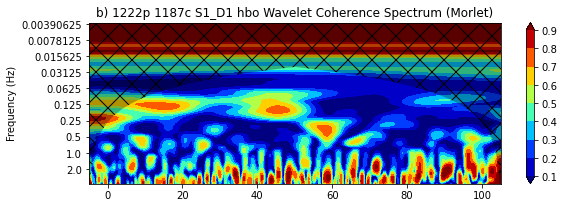

In [ ]:
# example WCT between a real dyad, puzzle block (1), iteration/trial 0 (0)
WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    epoch_df['1222p']['S1_D1 hbo'][2][3].copy(),
    epoch_df['1222c']['S1_D1 hbo'][2][3].copy(),
    plot=True)

# same WCT but a random false dyad
WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    epoch_df['1222p']['S1_D1 hbo'][2][3].copy(),
    epoch_df['1187c']['S1_D1 hbo'][2][3].copy(),
    plot=True)

In [ ]:
# list out all the subjects in the epoch df
epoch_df.keys()

dict_keys(['1125c', '1125p', '1146c', '1146p', '1167c', '1167p', '1133c', '1133p', '1174c', '1174p', '1219c', '1219p', '1226c', '1226p', '1247c', '1247p', '1141c', '1141p', '1112c', '1112p', '1232c', '1232p', '1252c', '1252p', '1207c', '1207p', '1127c', '1127p', '1173c', '1173p', '1270c', '1270p', '1223c', '1223p', '1147c', '1147p', '1209c', '1209p', '1240c', '1240p', '1151c', '1151p', '1165c', '1165p', '1104c', '1104p', '1246c', '1246p', '1164c', '1164p', '1155c', '1155p', '1228c', '1228p', '1116c', '1116p', '1189c', '1189p', '1178c', '1178p', '1188c', '1188p', '1227c', '1227p', '1114c', '1114p', '1202c', '1202p', '1187c', '1187p', '1264c', '1264p', '1216c', '1216p', '1200c', '1200p', '1168c', '1168p', '1225c', '1225p', '1193c', '1193p', '1184c', '1184p', '1211c', '1211p', '1102c', '1102p', '1122c', '1122p', '1182c', '1182p', '1258c', '1258p', '1256c', '1256p', '1139c', '1139p', '1186c', '1186p', '1137c', '1137p', '1179c', '1179p', '1269c', '1269p', '1159c', '1159p', '1266c', '1266p',

In [ ]:
# delete things we don't need anymore to save memory (ONLY RUN THIS IF YOU NEED TO CONDUCT A NEW PERMUTATION ANALYSIS)
del scans
del pps

In [ ]:
import random

In [ ]:
# ATTENTION READ THE FOLLOWING COMMENT CAREFULLY BEFORE PROCEEDING

In [ ]:
# make a new dictionary where the synchrony values will be stored
sync_df = {}
perm_df = {}
block_types = ['Block 1', 'Block 2', 'Block 3']
block_names = ['Pre-Play', 'Puzzle', 'Post-Puzzle']
trials = ['Trial 1', 'Trial 2', 'Trial 3', 'Trial 4']

# Real dyads only

# for every parent subject
for parent in tqdm([sub for sub in sorted(epoch_df.keys()) if sub.endswith("p")]):
    sync_df[parent] = {}
    base_id = parent[:-1]  # Remove "-P" to get the base ID
    child = base_id + "c"  # Construct child ID with "-C"
    
    if child in epoch_df:
        sync_df[parent][child] = {}
        
        # Loop over block types
        for block_num, block in enumerate(block_types):
            sync_df[parent][child][block] = {}
            
            # Loop over channels
            for ch in epoch_df[parent].keys():
                # Load in their epoched data for this subject / channel / block
                p_epoch = epoch_df[parent][ch][block_num].load_data()
                c_epoch = epoch_df[child][ch][block_num].load_data()

                # Loop over trials
                for block_it in np.arange(0, np.min([len(p_epoch), len(c_epoch)])):
                    try:
                        if f'Trial {block_it + 1}' not in sync_df[parent][child][block]:
                            sync_df[parent][child][block][f'Trial {block_it + 1}'] = {}
                    
                        WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
                            p_epoch[block_it], 
                            c_epoch[block_it], 
                            plot=False)

                        # Make values outside COI = np.nan
                        nanWCT = WCT
                        for t in range(nanWCT.shape[1]):
                            nanWCT[np.where(freqs > coi[t]), t] = np.nan

                        # Set to nan outside frequencies of interest
                        WCT[(5 > (1 / freqs)) | ((1 / freqs) > 105), :] = np.nan

                        # Store the average coherence in the structure
                        sync_df[parent][child][block][f'Trial {block_it + 1}'][ch] = np.nanmean(nanWCT)
                    
                    except Exception as e:
                        print(f"Fail @ parent {parent}, child {child}, block {block}, channel {ch}, block it {block_it}. Error: {e}")
    else:
        print(f"No matching child found for parent {parent}")



  0%|          | 0/109 [00:00<?, ?it/s]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1102p, child 1102c, block Block 1, channel S3_D2 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1102p, child 1102c, block Block

  1%|          | 1/109 [00:06<11:17,  6.27s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1104p, child 1104c, block Block 1, channel S2_D2 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1104p, child 1104c, block Block

  2%|▏         | 2/109 [00:12<11:06,  6.23s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw 

  3%|▎         | 3/109 [00:18<11:04,  6.27s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1112p, child 1112c, block Block 1, channel S2_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1112p, child 1112c, block Block 1, channel S2_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1112p, child 1112c, block Block 1, channel S2_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...

  4%|▎         | 4/109 [00:25<10:57,  6.27s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw 

  5%|▍         | 5/109 [00:31<10:54,  6.29s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1114p, child 1114c, block Block 1, channel S1_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1114p, child 1114c, block Block

  6%|▌         | 6/109 [00:37<10:46,  6.28s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1116p, child 1116c, block Block 1, channel S2_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1116p, child 1116c, block Block 1, channel S2_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1116p, child 1116c, block Block 1, channel S2_

  6%|▋         | 7/109 [00:43<10:36,  6.24s/it]

Fail @ parent 1116p, child 1116c, block Block 3, channel S8_D4 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1116p, child 1116c, block Block 3, channel S8_D4 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original 

  7%|▋         | 8/109 [00:50<10:31,  6.25s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1121p, child 1121c, block Block 1, channel S3_D2 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1121p, child 1121c, block Block

  8%|▊         | 9/109 [00:56<10:24,  6.24s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1122p, child 1122c, block Block 1, channel S2_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1122p, child 1122c, block Block 1, channel S2_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1122p, child 1122c, block Block 1, channel S2_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...

  9%|▉         | 10/109 [01:02<10:12,  6.19s/it]

Fail @ parent 1122p, child 1122c, block Block 3, channel S8_D4 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1122p, child 1122c, block Block 3, channel S8_D4 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1122p, child 1122c, block Block 3, channel S8_D4 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1124p, child 1124c, block Block 1, channel S1_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1124p, child 1124c, block Block 1, channel S1_D1 hbo, block it 3. Error: Can

 10%|█         | 11/109 [01:08<10:10,  6.23s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1125p, child 1125c, block Block 1, channel S2_D2 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1125p, child 1125c, block Block

 11%|█         | 12/109 [01:14<10:04,  6.23s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1126p, child 1126c, block Block 1, channel S3_D2 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1126p, child 1126c, block Block

 12%|█▏        | 13/109 [01:21<10:05,  6.31s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1127p, child 1127c, block Block 1, channel S2_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1127p, child 1127c, block Block

 13%|█▎        | 14/109 [01:27<10:03,  6.36s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1129p, child 1129c, block Block 1, channel S2_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events an

 14%|█▍        | 15/109 [01:34<10:04,  6.43s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw 

 15%|█▍        | 16/109 [01:41<10:03,  6.48s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1133p, child 1133c, block Block 1, channel S2_D2 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1133p, child 1133c, block Block

 16%|█▌        | 17/109 [01:47<10:02,  6.55s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1134p, child 1134c, block Block 1, channel S1_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1134p, child 1134c, block Block 1, channel S2_D2 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original 

 17%|█▋        | 18/109 [01:54<10:00,  6.60s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1137p, child 1137c, block Block 1, channel S2_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1137p, child 1137c, block Block 1, channel S2_D2 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original 

 17%|█▋        | 19/109 [02:01<09:52,  6.58s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1138p, child 1138c, block Block 1, channel S1_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events an

 18%|█▊        | 20/109 [02:07<09:41,  6.53s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1139p, child 1139c, block Block 1, channel S1_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1139p, child 1139c, block Block

 19%|█▉        | 21/109 [02:13<09:33,  6.52s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1141p, child 1141c, block Block 1, channel S1_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1141p, child 1141c, block Block 1, channel S2_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1141p, child 1141c, block Block 1, channel S2_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...

 20%|██        | 22/109 [02:20<09:23,  6.48s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1143p, child 1143c, block Block 1, channel S2_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events an

 21%|██        | 23/109 [02:26<09:17,  6.48s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1144p, child 1144c, block Block 1, channel S3_D2 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events an

 22%|██▏       | 24/109 [02:33<09:08,  6.45s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1145p, child 1145c, block Block 1, channel S2_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1145p, child 1145c, block Block 1, channel S2_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original 

 23%|██▎       | 25/109 [02:39<09:00,  6.43s/it]

Fail @ parent 1145p, child 1145c, block Block 3, channel S8_D4 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1146p, child 1146c, block Block 1, channel S1_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1146p, child 1146c, block Block 1, channel S1_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1146p, child 1146c, block Block 1, channel S2_D1 hbo, block i

 24%|██▍       | 26/109 [02:45<08:51,  6.41s/it]

Fail @ parent 1146p, child 1146c, block Block 3, channel S8_D4 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1147p, child 1147c, block Block 1, channel S1_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1147p, child 1147c, block Block 1, channel S2_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...

 25%|██▍       | 27/109 [02:52<08:41,  6.36s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw 

 26%|██▌       | 28/109 [02:58<08:36,  6.38s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1149p, child 1149c, block Block 1, channel S2_D2 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1149p, child 1149c, block Block

 27%|██▋       | 29/109 [03:04<08:27,  6.35s/it]

Fail @ parent 1149p, child 1149c, block Block 3, channel S8_D4 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1151p, child 1151c, block Block 1, channel S2_D2 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1151p, child 1151c, block Block 1, channel S2_

 28%|██▊       | 30/109 [03:11<08:23,  6.37s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw 

 28%|██▊       | 31/109 [03:17<08:18,  6.38s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1155p, child 1155c, block Block 1, channel S3_D2 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events an

 29%|██▉       | 32/109 [03:24<08:11,  6.39s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1156p, child 1156c, block Block 1, channel S1_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1156p, child 1156c, block Block 1, channel S2_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original 

 30%|███       | 33/109 [03:30<08:04,  6.37s/it]

Fail @ parent 1156p, child 1156c, block Block 3, channel S8_D4 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1156p, child 1156c, block Block 3, channel S8_D4 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1156p, child 1156c, block Block 3, channel S8_D4 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1156p, child 1156c, block Block 3, channel S8_D4 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs d

 31%|███       | 34/109 [03:37<08:10,  6.54s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1160p, child 1160c, block Block 1, channel S2_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1160p, child 1160c, block Block 1, channel S2_D2 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original 

 32%|███▏      | 35/109 [03:43<08:02,  6.53s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1162p, child 1162c, block Block 1, channel S2_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1162p, child 1162c, block Block 1, channel S2_D2 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1162p, child 1162c, block Block 1, channel S2_

 33%|███▎      | 36/109 [03:50<07:54,  6.50s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1164p, child 116

 34%|███▍      | 37/109 [03:56<07:50,  6.54s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw 

 35%|███▍      | 38/109 [04:03<07:45,  6.56s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1167p, child 1167c, block Block 1, channel S3_D2 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events an

 36%|███▌      | 39/109 [04:10<07:40,  6.57s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1168p, child 116

 37%|███▋      | 40/109 [04:16<07:35,  6.60s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1170p, child 1170c, block Block 1, channel S1_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1170p, child 1170c, block Block 1, channel S2_D2 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original 

 38%|███▊      | 41/109 [04:23<07:31,  6.64s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
1 bad epochs dropped
Using data from preloaded Raw 

 39%|███▊      | 42/109 [04:29<07:13,  6.47s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1173p, child 1173c, block Block 1, channel S1_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1173p, child 1173c, block Block 1, channel S1_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original 

 39%|███▉      | 43/109 [04:36<07:09,  6.51s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1174p, child 1174c, block Block 1, channel S1_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1174p, child 1174c, block Block 1, channel S2_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1174p, child 1174c, block Block 1, channel S2_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...

 40%|████      | 44/109 [04:42<07:04,  6.54s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1175p, child 1175c, block Block 1, channel S1_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1175p, child 1175c, block Block 1, channel S2_D2 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1175p, child 1175c, block Block 1, channel S2_

 41%|████▏     | 45/109 [04:49<06:57,  6.52s/it]

Fail @ parent 1175p, child 1175c, block Block 3, channel S8_D4 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events an

 42%|████▏     | 46/109 [04:55<06:52,  6.54s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1178p, child 117

 43%|████▎     | 47/109 [05:02<06:47,  6.57s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1179p, child 1179c, block Block 1, channel S2_D2 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1179p, child 1179c, block Block 1, channel S2_D2 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original 

 44%|████▍     | 48/109 [05:09<06:40,  6.57s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1180p, child 1180c, block Block 1, channel S1_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1180p, child 1180c, block Block 1, channel S2_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1180p, child 1180c, block Block 1, channel S2_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1180p, child 1180c, block Block 1, channel S2_D1 hbo, block i

 45%|████▍     | 49/109 [05:15<06:34,  6.57s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1182p, child 1182c, block Block 1, channel S2_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1182p, child 1182c, block Block

 46%|████▌     | 50/109 [05:22<06:29,  6.60s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1184p, child 1184c, block Block 1, channel S1_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1184p, child 1184c, block Block 1, channel S2_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1184p, child 1184c, block Block 1, channel S2_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1184p, child 1184c, block Block 1, channel S2_D1 hbo, block i

 47%|████▋     | 51/109 [05:28<06:22,  6.59s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1185p, child 1185c, block Block 1, channel S1_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1185p, child 1185c, block Block 1, channel S2_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1185p, child 1185c, block Block 1, channel S2_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1185p, child 1185c, block Block 1, channel S2_D1 hbo, block i

 48%|████▊     | 52/109 [05:35<06:15,  6.58s/it]

Fail @ parent 1185p, child 1185c, block Block 3, channel S8_D4 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1186p, child 1186c, block Block

 49%|████▊     | 53/109 [05:41<06:08,  6.57s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1187p, child 1187c, block Block 1, channel S3_D2 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events an

 50%|████▉     | 54/109 [05:48<06:02,  6.59s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1188p, child 1188c, block Block 1, channel S2_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1188p, child 1188c, block Block

 50%|█████     | 55/109 [05:55<05:53,  6.55s/it]

Fail @ parent 1188p, child 1188c, block Block 3, channel S8_D4 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1189p, child 1189c, block Block 1, channel S1_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1189p, child 1189c, block Block 1, channel S1_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1189p, child 1189c, block Block 1, channel S2_D1 hbo, block i

 51%|█████▏    | 56/109 [06:01<05:42,  6.47s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1190p, child 1190c, block Block 1, channel S1_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1190p, child 1190c, block Block 1, channel S1_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1190p, child 1190c, block Block 1, channel S2_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1190p, child 1190c, block Block 1, channel S2_D1 hbo, block i

 52%|█████▏    | 57/109 [06:07<05:33,  6.41s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1193p, child 1193c, block Block 1, channel S1_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events an

 53%|█████▎    | 58/109 [06:13<05:26,  6.39s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1194p, child 1194c, block Block 1, channel S1_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1194p, child 1194c, block Block 1, channel S1_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1194p, child 1194c, block Block 1, channel S2_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...

 54%|█████▍    | 59/109 [06:20<05:20,  6.41s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1195p, child 1195c, block Block 1, channel S2_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1195p, child 1195c, block Block 1, channel S2_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original 

 55%|█████▌    | 60/109 [06:26<05:13,  6.40s/it]

Fail @ parent 1195p, child 1195c, block Block 3, channel S8_D4 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events an

 56%|█████▌    | 61/109 [06:33<05:07,  6.41s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1202p, child 1202c, block Block 1, channel S1_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1202p, child 1202c, block Block 1, channel S2_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1202p, child 1202c, block Block 1, channel S2_

 57%|█████▋    | 62/109 [06:39<05:02,  6.43s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw 

 58%|█████▊    | 63/109 [06:46<04:55,  6.43s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw 

 59%|█████▊    | 64/109 [06:52<04:49,  6.44s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1205p, child 1205c, block Block 1, channel S2_D2 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1205p, child 1205c, block Block

 60%|█████▉    | 65/109 [06:59<04:42,  6.42s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1207p, child 1207c, block Block 1, channel S3_D2 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1207p, child 1207c, block Block

 61%|██████    | 66/109 [07:05<04:35,  6.40s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1209p, child 1209c, block Block 1, channel S1_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1209p, child 1209c, block Block

 61%|██████▏   | 67/109 [07:10<04:09,  5.95s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1211p, child 1211c, block Block 1, channel S2_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events an

 62%|██████▏   | 68/109 [07:16<04:09,  6.07s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1213p, child 1213c, block Block 1, channel S1_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1213p, child 1213c, block Block 1, channel S1_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1213p, child 1213c, block Block 1, channel S1_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1213p, child 1213c, block Block 1, channel S1_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs d

 63%|██████▎   | 69/109 [07:22<04:04,  6.12s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1214p, child 1214c, block Block 1, channel S1_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1214p, child 1214c, block Block 1, channel S1_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1214p, child 1214c, block Block 1, channel S2_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...

 64%|██████▍   | 70/109 [07:29<04:02,  6.22s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1216p, child 1216c, block Block 1, channel S2_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1216p, child 1216c, block Block 1, channel S2_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original 

 65%|██████▌   | 71/109 [07:35<03:59,  6.29s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1219p, child 1219c, block Block 1, channel S1_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events an

 66%|██████▌   | 72/109 [07:42<03:55,  6.36s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1220p, child 1220c, block Block 1, channel S2_D2 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1220p, child 1220c, block Block 1, channel S2_D2 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original 

 67%|██████▋   | 73/109 [07:48<03:49,  6.38s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1222p, child 1222c, block Block 1, channel S1_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1222p, child 1222c, block Block 1, channel S2_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original 

 68%|██████▊   | 74/109 [07:55<03:43,  6.38s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1223p, child 1223c, block Block 1, channel S1_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1223p, child 1223c, block Block 1, channel S1_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1223p, child 1223c, block Block 1, channel S2_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...

 69%|██████▉   | 75/109 [08:01<03:36,  6.38s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw 

 70%|██████▉   | 76/109 [08:07<03:30,  6.39s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1226p, child 1226c, block Block 1, channel S3_D2 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events an

 71%|███████   | 77/109 [08:14<03:25,  6.43s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw 

 72%|███████▏  | 78/109 [08:20<03:18,  6.41s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1228p, child 1228c, block Block 1, channel S3_D2 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events an

 72%|███████▏  | 79/109 [08:27<03:12,  6.43s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1229p, child 1229c, block Block 1, channel S1_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1229p, child 1229c, block Block

 73%|███████▎  | 80/109 [08:33<03:06,  6.42s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1231p, child 1231c, block Block 1, channel S3_D2 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1231p, child 1231c, block Block

 74%|███████▍  | 81/109 [08:40<02:59,  6.42s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1232p, child 1232c, block Block 1, channel S1_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1232p, child 1232c, block Block

 75%|███████▌  | 82/109 [08:46<02:53,  6.43s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
1 bad epochs dropped
Fail @ parent 1234p, child 1234c, block Block 1, channel S2_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
1 bad epochs dropped
Fail @ parent 1234p, child 1234c, block Block

 76%|███████▌  | 83/109 [08:52<02:42,  6.25s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1235p, child 1235c, block Block 1, channel S1_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1235p, child 1235c, block Block 1, channel S1_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1235p, child 1235c, block Block 1, channel S1_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1235p, child 1235c, block Block 1, channel S2_D1 hbo, block i

 77%|███████▋  | 84/109 [08:58<02:36,  6.26s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1236p, child 1236c, block Block 1, channel S1_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1236p, child 1236c, block Block 1, channel S1_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1236p, child 1236c, block Block 1, channel S2_

 78%|███████▊  | 85/109 [09:04<02:30,  6.28s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1240p, child 124

 79%|███████▉  | 86/109 [09:11<02:24,  6.28s/it]

Fail @ parent 1240p, child 1240c, block Block 3, channel S8_D4 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1242p, child 1242c, block Block 1, channel S1_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1242p, child 1242c, block Block 1, channel S2_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...

 80%|███████▉  | 87/109 [09:17<02:18,  6.31s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1243p, child 1243c, block Block 1, channel S1_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1243p, child 1243c, block Block 1, channel S2_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1243p, child 1243c, block Block 1, channel S2_

 81%|████████  | 88/109 [09:23<02:12,  6.33s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1244p, child 1244c, block Block 1, channel S2_D2 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1244p, child 1244c, block Block 1, channel S2_D2 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original 

 82%|████████▏ | 89/109 [09:30<02:06,  6.33s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1245p, child 1245c, block Block 1, channel S2_D2 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1245p, child 1245c, block Block

 83%|████████▎ | 90/109 [09:36<02:00,  6.36s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1246p, child 1246c, block Block 1, channel S1_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1246p, child 1246c, block Block 1, channel S2_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1246p, child 1246c, block Block 1, channel S2_

 83%|████████▎ | 91/109 [09:43<01:54,  6.34s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw 

 84%|████████▍ | 92/109 [09:49<01:48,  6.37s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1248p, child 1248c, block Block 1, channel S3_D2 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events an

 85%|████████▌ | 93/109 [09:55<01:42,  6.38s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1250p, child 1250c, block Block 1, channel S1_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1250p, child 1250c, block Block 1, channel S2_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1250p, child 1250c, block Block 1, channel S2_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...

 86%|████████▌ | 94/109 [10:02<01:35,  6.38s/it]

Fail @ parent 1250p, child 1250c, block Block 3, channel S8_D4 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1251p, child 1251c, block Block 1, channel S2_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original 

 87%|████████▋ | 95/109 [10:08<01:29,  6.37s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1252p, child 1252c, block Block 1, channel S1_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1252p, child 1252c, block Block 1, channel S2_D2 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original 

 88%|████████▊ | 96/109 [10:15<01:22,  6.38s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw 

 89%|████████▉ | 97/109 [10:21<01:16,  6.41s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1254p, child 1254c, block Block 1, channel S2_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events an

 90%|████████▉ | 98/109 [10:27<01:10,  6.42s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1255p, child 1255c, block Block 1, channel S2_D2 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events an

 91%|█████████ | 99/109 [10:34<01:04,  6.44s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1256p, child 1256c, block Block 1, channel S1_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1256p, child 1256c, block Block 1, channel S1_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1256p, child 1256c, block Block 1, channel S1_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...

 92%|█████████▏| 100/109 [10:40<00:57,  6.42s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1258p, child 1258c, block Block 1, channel S1_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1258p, child 1258c, block Block

 93%|█████████▎| 101/109 [10:47<00:51,  6.38s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1263p, child 1263c, block Block 1, channel S1_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1263p, child 1263c, block Block 1, channel S1_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1263p, child 1263c, block Block 1, channel S2_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1263p, child 1263c, block Block 1, channel S2_D1 hbo, block i

 94%|█████████▎| 102/109 [10:53<00:44,  6.41s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1264p, child 1264c, block Block 1, channel S3_D2 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1264p, child 1264c, block Block

 94%|█████████▍| 103/109 [11:00<00:38,  6.42s/it]

Fail @ parent 1264p, child 1264c, block Block 3, channel S8_D4 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1265p, child 1265c, block Block 1, channel S2_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1265p, child 1265c, block Block 1, channel S2_

 95%|█████████▌| 104/109 [11:06<00:31,  6.40s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1266p, child 1266c, block Block 1, channel S1_D1 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1266p, child 1266c, block Block 1, channel S1_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1266p, child 1266c, block Block 1, channel S2_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...

 96%|█████████▋| 105/109 [11:12<00:25,  6.38s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1267p, child 1267c, block Block 1, channel S1_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1267p, child 1267c, block Block 1, channel S2_D2 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original 

 97%|█████████▋| 106/109 [11:19<00:19,  6.38s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1268p, child 1268c, block Block 1, channel S1_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1268p, child 1268c, block Block 1, channel S2_D1 hbo, block it 0. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1268p, child 1268c, block Block 1, channel S2_D1 hbo, block it 1. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Fail @ parent 1268p, child 1268c, block Block 1, channel S2_D1 hbo, block i

 98%|█████████▊| 107/109 [11:25<00:12,  6.42s/it]

Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1269p, child 1269c, block Block 1, channel S2_D2 hbo, block it 2. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1269p, child 1269c, block Block

 99%|█████████▉| 108/109 [11:31<00:06,  6.39s/it]

Fail @ parent 1269p, child 1269c, block Block 3, channel S8_D4 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1270p, child 1270c, block Block 1, channel S1_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 4 events and 860 original time points ...
0 bad epochs dropped
Fail @ parent 1270p, child 1270c, block Block 1, channel S2_D1 hbo, block it 3. Error: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.
Using data from preloaded Raw for 4 events and 860 original time points ...

100%|██████████| 109/109 [11:38<00:00,  6.41s/it]


In [ ]:
#Can use this to check that this variable has been created (important so you can save it in the next step) but the output is very long so clear the output before you continue
sync_df

{'1102p': {'1102c': {'Block 1': {'Trial 1': {'S1_D1 hbo': 0.5351201718378387,
     'S2_D1 hbo': 0.5560337569620821,
     'S2_D2 hbo': 0.3649676951232257,
     'S3_D2 hbo': 0.3198808892810302,
     'S4_D2 hbo': 0.4408984305575352,
     'S6_D3 hbo': 0.3255521665936125,
     'S7_D3 hbo': 0.3121258915606851,
     'S7_D4 hbo': 0.5370937744805631,
     'S8_D4 hbo': 0.4527765160780834},
    'Trial 2': {'S1_D1 hbo': 0.4480608638151213,
     'S2_D1 hbo': 0.40394169099817445,
     'S2_D2 hbo': 0.48536704133925634,
     'S3_D2 hbo': 0.3671161281575319,
     'S6_D3 hbo': 0.3950527063632505,
     'S7_D3 hbo': 0.3784657299329051,
     'S7_D4 hbo': 0.4076815193678202,
     'S8_D4 hbo': 0.3221437716031043},
    'Trial 3': {'S1_D1 hbo': 0.42222478516350265,
     'S2_D1 hbo': 0.3465864701019364,
     'S2_D2 hbo': 0.41775402036845066,
     'S4_D2 hbo': 0.31777124143116525,
     'S6_D3 hbo': 0.4386678536594459,
     'S7_D3 hbo': 0.4411010804780874,
     'S7_D4 hbo': 0.5272603250440238,
     'S8_D4 hbo': 0

In [ ]:
list(sync_df['1222p']['1222c']['Block 1']['Trial 1'].values())

[0.4677101849103058,
 0.26555844438854337,
 0.25699528244744485,
 0.38104250921566585,
 0.26604270872675573,
 0.36806857099680046,
 0.2998448814132897,
 0.4364437362777001,
 0.23060811927866345]

In [ ]:
#important to set channels here
channels = epoch_df[parent].keys()

In [ ]:
epoch_df['1222p']

{'S1_D1 hbo': [<Epochs |  4 events (all good), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~40 kB, data loaded,
   'Block 1': 4>,
  <Epochs |  4 events (all good), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~40 kB, data loaded,
   'Block 2': 4>,
  <Epochs |  4 events (all good), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~40 kB, data loaded,
   'Block 3': 4>],
 'S2_D1 hbo': [<Epochs |  4 events (all good), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~40 kB, data loaded,
   'Block 1': 4>,
  <Epochs |  4 events (all good), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~40 kB, data loaded,
   'Block 2': 4>,
  <Epochs |  4 events (all good), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~40 kB, data loaded,
   'Block 3': 4>],
 'S2_D2 hbo': [<Epochs |  4 events (all good), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~40 kB, data loaded,
   'Block 1': 4>,
  <Epochs |  4 events (all good), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~40 kB, data loaded,
   'Block 2': 4>,
  <Epoc

In [ ]:
channels

dict_keys(['S1_D1 hbo', 'S2_D1 hbo', 'S2_D2 hbo', 'S3_D2 hbo', 'S4_D2 hbo', 'S5_D3 hbo', 'S6_D3 hbo', 'S7_D3 hbo', 'S7_D4 hbo', 'S8_D4 hbo'])

In [ ]:
#Can use this to check that this variable has been created (important so you can save it in the next step) but the output is very long so clear the output before you continue
sync_df

{'1102p': {'1102c': {'Block 1': {'Trial 1': {'S1_D1 hbo': 0.5351201718378387,
     'S2_D1 hbo': 0.5560337569620821,
     'S2_D2 hbo': 0.3649676951232257,
     'S3_D2 hbo': 0.3198808892810302,
     'S4_D2 hbo': 0.4408984305575352,
     'S6_D3 hbo': 0.3255521665936125,
     'S7_D3 hbo': 0.3121258915606851,
     'S7_D4 hbo': 0.5370937744805631,
     'S8_D4 hbo': 0.4527765160780834},
    'Trial 2': {'S1_D1 hbo': 0.4480608638151213,
     'S2_D1 hbo': 0.40394169099817445,
     'S2_D2 hbo': 0.48536704133925634,
     'S3_D2 hbo': 0.3671161281575319,
     'S6_D3 hbo': 0.3950527063632505,
     'S7_D3 hbo': 0.3784657299329051,
     'S7_D4 hbo': 0.4076815193678202,
     'S8_D4 hbo': 0.3221437716031043},
    'Trial 3': {'S1_D1 hbo': 0.42222478516350265,
     'S2_D1 hbo': 0.3465864701019364,
     'S2_D2 hbo': 0.41775402036845066,
     'S4_D2 hbo': 0.31777124143116525,
     'S6_D3 hbo': 0.4386678536594459,
     'S7_D3 hbo': 0.4411010804780874,
     'S7_D4 hbo': 0.5272603250440238,
     'S8_D4 hbo': 0

In [ ]:
import json
import pandas as pd
json_object = json.dumps(sync_df, indent=4)

# Assuming sync_df is your nested dictionary as shown above
# If it's not already loaded, you can load it from the JSON file like this:
with open("wct_permuted_values.json", 'w') as outfile:
    json.dump(sync_df, outfile)

# Define your columns here, but leave channels dynamic, as they'll be added based on the data
cols = ["Parent", "Child", "Block", "Trial"]

for ch in channels:
    cols.append(ch)

# Initialize an empty DataFrame with predefined columns
df = pd.DataFrame(columns=cols)

# Iterate through the nested dictionary
for parent, children in sync_df.items():
    for child, blocks in children.items():
        for block, trials in blocks.items():
            for trial, channels in trials.items():
                # Initialize a dictionary to hold the row data
                dic = {
                    'Parent': parent, 
                    'Child': child, 
                    'Block': block, 
                    'Trial': trial}
                for key, val in sync_df[parent][child][block][trial].items():
                    dic[key] = val
                # Append the row to the DataFrame
                df = df.append(dic, ignore_index=True)

# Display the DataFrame to verify its structure
print(df)

# Save the DataFrame to CSV
df.to_csv("wct_permuted_values_real-dyads-only.csv", index=False)


     Parent  Child    Block    Trial  S1_D1 hbo  S2_D1 hbo  S2_D2 hbo  \
0     1102p  1102c  Block 1  Trial 1   0.535120   0.556034   0.364968   
1     1102p  1102c  Block 1  Trial 2   0.448061   0.403942   0.485367   
2     1102p  1102c  Block 1  Trial 3   0.422225   0.346586   0.417754   
3     1102p  1102c  Block 1  Trial 4   0.308147   0.340894   0.411721   
4     1102p  1102c  Block 2  Trial 1   0.306300   0.277010   0.350705   
...     ...    ...      ...      ...        ...        ...        ...   
1298  1270p  1270c  Block 2  Trial 4   0.287844   0.395261   0.452332   
1299  1270p  1270c  Block 3  Trial 1   0.345030        NaN        NaN   
1300  1270p  1270c  Block 3  Trial 2   0.277540   0.334586   0.365695   
1301  1270p  1270c  Block 3  Trial 3        NaN        NaN   0.396561   
1302  1270p  1270c  Block 3  Trial 4   0.276749   0.403171   0.354425   

      S3_D2 hbo  S4_D2 hbo  S5_D3 hbo  S6_D3 hbo  S7_D3 hbo  S7_D4 hbo  \
0      0.319881   0.440898        NaN   0.325552 

In [ ]:
# Save permuted values

json_object = json.dumps(perm_df, indent=4)
with open("permuted_subjects_real-dyads-only.json", 'w') as outfile:
    json.dump(perm_df, outfile)

In [ ]:
# LOAD PERMUTED SYNCHRONY VALUES from the saved file, saving time and precious CPU-hours

import json
with open("permuted_subjects.json", 'r') as infile:
    perm_df = json.load(infile)

In [ ]:
# LOAD REAL SYNCHRONY VALUES from the saved file, saving time and precious CPU-hours

import json
with open("wct_permuted_values.json", 'r') as infile:
    sync_df = json.load(infile)

In [ ]:
list(epoch_df['1147p'].keys())

['S1_D1 hbo',
 'S2_D1 hbo',
 'S2_D2 hbo',
 'S3_D2 hbo',
 'S4_D2 hbo',
 'S5_D3 hbo',
 'S6_D3 hbo',
 'S7_D3 hbo',
 'S7_D4 hbo',
 'S8_D4 hbo']

In [ ]:
epoch_df['1202p'].keys()

dict_keys(['S1_D1 hbo', 'S2_D1 hbo', 'S2_D2 hbo', 'S3_D2 hbo', 'S4_D2 hbo', 'S5_D3 hbo', 'S6_D3 hbo', 'S7_D3 hbo', 'S7_D4 hbo', 'S8_D4 hbo'])

In [ ]:
# how many parents are in there (some may be repeated because they have multiple children in the study)
len(sync_df.keys())

109

In [ ]:
# how many parents are in there, without repeats
len(set([sub[:-1] for sub in list(sync_df.keys())]))

109